In [1]:
def Auto_MSG_SE_Densenet_GAN(vy,vx,upscale,test_size=0.25,if_best_mode='no',modelpath=None,conv_core_num=512,model_deep=5,Vgg_deep=5,se_radio=0.5,if_weight_initialize='no',weight_initialize_method='TruncatedNormal',weight_initialize_parameter1=0.00,weight_initialize_parameter2=0.05,loss_function='default',if_print_model='yes',optimizer='SGD',g_learning_rate=0.001,d_learning_rate=0.01,epochs=2000,g_train_time=2,ifrandom_split='yes',ifmute='no',ifsave='no',savepath=None,device='cpu'):
    import tensorflow as tf
    from keras.models import Sequential,Model
    import math
    from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
    from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply
    from sklearn.model_selection import train_test_split
    import numpy as np
    from tensorflow.keras.optimizers import SGD,Adam
    from scipy.stats import pearsonr
    from keras.models import load_model
    import os
    from sklearn.metrics import accuracy_score,log_loss
    import keras.backend as K
        
    if vx.ndim==3:
        vx=np.array(vx).reshape(vx.shape[0],vx.shape[1],vx.shape[2],1)
    if vy.ndim==3:
        vy=np.array(vy).reshape(vy.shape[0],vy.shape[1],vy.shape[2],1)
    if ifrandom_split=='yes':
        trainx,testx,trainy,testy = train_test_split(vx,vy,test_size=test_size,random_state=25)
    else:
        index=int((1-test_size)*vy.shape[0])
        trainy=vy[:index,:,:,:]
        testy=vy[index:,:,:,:]
        trainx=vx[:index,:,:,:]
        testx=vx[index:,:,:,:]
    if device=='gpu':
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
        tf.device('/gpu:0')
        if optimizer == 'SGD':
            g_opt = SGD(lr = g_learning_rate)
            d_opt = SGD(lr = d_learning_rate)
        elif optimizer == 'Adam':
            g_opt = Adam(lr = g_learning_rate)
            d_opt = Adam(lr = d_learning_rate)
        def build_generator(trainy,generator_input,model_deep,conv_core_num,upscale,se_radio,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2):
            import tensorflow as tf
            from keras.models import Sequential,Model
            import math
            from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
            from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply
            from sklearn.model_selection import train_test_split
            import numpy as np
            from tensorflow.keras.optimizers import SGD,Adam
            from scipy.stats import pearsonr
            from keras.models import load_model
            import os
            generator_inputs=Input(shape=(generator_input.shape[1],generator_input.shape[2],vx.shape[3]))
            if if_weight_initialize=='no':
                exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same")(generator_inputs)')
            else:
                if weight_initialize_method=='RandomNormal':
                    exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_inputs)')
                elif weight_initialize_method=='RandomUniform':
                    exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_inputs)')
                elif weight_initialize_method=='TruncatedNormal':
                    exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_inputs)')
            exec('generator_act_start_1=Activation("leaky_relu")(generator_conv_start_1)')
            if if_weight_initialize=='no':
                exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same")(generator_act_start_1)')
            else:
                if weight_initialize_method=='RandomNormal':
                    exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act_start_1)')
                elif weight_initialize_method=='RandomUniform':
                    exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act_start_1)')
                elif weight_initialize_method=='TruncatedNormal':
                    exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act_start_1)')
            exec('generator_act_start_2=Activation("leaky_relu")(generator_conv_start_2)')
            exec('segap_start=GlobalAveragePooling2D()(generator_act_start_2)')
            exec('sefc_start_1=Dense(int(conv_core_num*se_radio))(segap_start)')
            exec('seact_start_1=Activation("leaky_relu")(sefc_start_1)')
            exec('sefc_start_2=Dense(conv_core_num)(seact_start_1)')
            exec('seact_start_2=Activation("leaky_relu")(sefc_start_2)')
            exec('semulti_start=Multiply()([generator_act_start_2,seact_start_2])')
            exec('seadd_start=Add()([semulti_start,generator_act_start_2])')
            for i in range(model_deep):
                if i==0:
                    exec('generator_upsample_'+str(i+1)+'=UpSampling2D(size=(upscale,upscale))(seadd_start)')
                else:
                    exec('generator_upsample_'+str(i+1)+'=UpSampling2D(size=(upscale,upscale))(generator_act'+str(i)+'_2)')             
                if if_weight_initialize=='no':
                    exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same")(generator_upsample_'+str(i+1)+')')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                exec('generator_act'+str(i+1)+'_1=Activation("leaky_relu")(generator_conv'+str(i+1)+'_1)')
                if if_weight_initialize=='no':
                    exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same")(generator_act'+str(i+1)+'_1)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                exec('generator_act'+str(i+1)+'_2=Activation("leaky_relu")(generator_conv'+str(i+1)+'_2)')
            if if_weight_initialize=='no':
                generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same")(generator_act'+str(i+1)+'_2)')
            else:
                if weight_initialize_method=='RandomNormal':
                    generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                elif weight_initialize_method=='RandomUniform':
                    generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                elif weight_initialize_method=='TruncatedNormal':
                    generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
            return Model(inputs=generator_inputs, outputs=generator_output)
        def build_discriminator(trainy,discriminator_input,model_deep,upscale,conv_core_num,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2):
            import tensorflow as tf
            from keras.models import Sequential,Model
            import math
            from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
            from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply
            from sklearn.model_selection import train_test_split
            import numpy as np
            from tensorflow.keras.optimizers import SGD,Adam
            from scipy.stats import pearsonr
            from keras.models import load_model
            import os
            from keras.layers import Layer, InputSpec
            from keras import initializers
            from keras import regularizers
            from keras import constraints
            from keras import backend as K

            from keras.utils.generic_utils import get_custom_objects
            class GroupNormalization(Layer):
                """Group normalization layer

                Group Normalization divides the channels into groups and computes within each group
                the mean and variance for normalization. GN's computation is independent of batch sizes,
                and its accuracy is stable in a wide range of batch sizes

                # Arguments
                    groups: Integer, the number of groups for Group Normalization.
                    axis: Integer, the axis that should be normalized
                        (typically the features axis).
                        For instance, after a `Conv2D` layer with
                        `data_format="channels_first"`,
                        set `axis=1` in `BatchNormalization`.
                    epsilon: Small float added to variance to avoid dividing by zero.
                    center: If True, add offset of `beta` to normalized tensor.
                        If False, `beta` is ignored.
                    scale: If True, multiply by `gamma`.
                        If False, `gamma` is not used.
                        When the next layer is linear (also e.g. `nn.relu`),
                        this can be disabled since the scaling
                        will be done by the next layer.
                    beta_initializer: Initializer for the beta weight.
                    gamma_initializer: Initializer for the gamma weight.
                    beta_regularizer: Optional regularizer for the beta weight.
                    gamma_regularizer: Optional regularizer for the gamma weight.
                    beta_constraint: Optional constraint for the beta weight.
                    gamma_constraint: Optional constraint for the gamma weight.

                # Input shape
                    Arbitrary. Use the keyword argument `input_shape`
                    (tuple of integers, does not include the samples axis)
                    when using this layer as the first layer in a model.

                # Output shape
                    Same shape as input.

                # References
                    - [Group Normalization](https://arxiv.org/abs/1803.08494)
                """

                def __init__(self,
                             groups=2,
                             axis=-1,
                             epsilon=1e-5,
                             center=True,
                             scale=True,
                             beta_initializer='zeros',
                             gamma_initializer='ones',
                             beta_regularizer=None,
                             gamma_regularizer=None,
                             beta_constraint=None,
                             gamma_constraint=None,
                             **kwargs):
                    super(GroupNormalization, self).__init__(**kwargs)
                    self.supports_masking = True
                    self.groups = groups
                    self.axis = axis
                    self.epsilon = epsilon
                    self.center = center
                    self.scale = scale
                    self.beta_initializer = initializers.get(beta_initializer)
                    self.gamma_initializer = initializers.get(gamma_initializer)
                    self.beta_regularizer = regularizers.get(beta_regularizer)
                    self.gamma_regularizer = regularizers.get(gamma_regularizer)
                    self.beta_constraint = constraints.get(beta_constraint)
                    self.gamma_constraint = constraints.get(gamma_constraint)

                def build(self, input_shape):
                    dim = input_shape[self.axis]

                    if dim is None:
                        raise ValueError('Axis ' + str(self.axis) + ' of '
                                         'input tensor should have a defined dimension '
                                         'but the layer received an input with shape ' +
                                         str(input_shape) + '.')

                    if dim < self.groups:
                        raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                                         'more than the number of channels (' +
                                         str(dim) + ').')

                    if dim % self.groups != 0:
                        raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                                         'multiple of the number of channels (' +
                                         str(dim) + ').')

                    self.input_spec = InputSpec(ndim=len(input_shape),
                                                axes={self.axis: dim})
                    shape = (dim,)

                    if self.scale:
                        self.gamma = self.add_weight(shape=shape,
                                                     name='gamma',
                                                     initializer=self.gamma_initializer,
                                                     regularizer=self.gamma_regularizer,
                                                     constraint=self.gamma_constraint)
                    else:
                        self.gamma = None
                    if self.center:
                        self.beta = self.add_weight(shape=shape,
                                                    name='beta',
                                                    initializer=self.beta_initializer,
                                                    regularizer=self.beta_regularizer,
                                                    constraint=self.beta_constraint)
                    else:
                        self.beta = None
                    self.built = True

                def call(self, inputs, **kwargs):
                    input_shape = K.int_shape(inputs)
                    tensor_input_shape = K.shape(inputs)

                    # Prepare broadcasting shape.
                    reduction_axes = list(range(len(input_shape)))
                    del reduction_axes[self.axis]
                    broadcast_shape = [1] * len(input_shape)
                    broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
                    broadcast_shape.insert(1, self.groups)

                    reshape_group_shape = K.shape(inputs)
                    group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
                    group_axes[self.axis] = input_shape[self.axis] // self.groups
                    group_axes.insert(1, self.groups)

                    # reshape inputs to new group shape
                    group_shape = [group_axes[0], self.groups] + group_axes[2:]
                    group_shape = K.stack(group_shape)
                    inputs = K.reshape(inputs, group_shape)

                    group_reduction_axes = list(range(len(group_axes)))
                    group_reduction_axes = group_reduction_axes[2:]

                    mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
                    variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

                    inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

                    # prepare broadcast shape
                    inputs = K.reshape(inputs, group_shape)
                    outputs = inputs

                    # In this case we must explicitly broadcast all parameters.
                    if self.scale:
                        broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
                        outputs = outputs * broadcast_gamma

                    if self.center:
                        broadcast_beta = K.reshape(self.beta, broadcast_shape)
                        outputs = outputs + broadcast_beta

                    outputs = K.reshape(outputs, tensor_input_shape)

                    return outputs

                def get_config(self):
                    config = {
                        'groups': self.groups,
                        'axis': self.axis,
                        'epsilon': self.epsilon,
                        'center': self.center,
                        'scale': self.scale,
                        'beta_initializer': initializers.serialize(self.beta_initializer),
                        'gamma_initializer': initializers.serialize(self.gamma_initializer),
                        'beta_regularizer': regularizers.serialize(self.beta_regularizer),
                        'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
                        'beta_constraint': constraints.serialize(self.beta_constraint),
                        'gamma_constraint': constraints.serialize(self.gamma_constraint)
                    }
                    base_config = super(GroupNormalization, self).get_config()
                    return dict(list(base_config.items()) + list(config.items()))

                def compute_output_shape(self, input_shape):
                    return input_shape
            
            discriminator_inputs=Input(shape=(discriminator_input.shape[1],discriminator_input.shape[2],discriminator_input.shape[3]))
            if if_weight_initialize=='no':
                exec('discriminator_conv_start_1=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same")(discriminator_inputs)')
            else:
                if weight_initialize_method=='RandomNormal':
                    exec('discriminator_conv_start_1=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_inputs)')
                elif weight_initialize_method=='RandomUniform':
                    exec('discriminator_conv_start_1=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_inputs)')
                elif weight_initialize_method=='TruncatedNormal':
                    exec('discriminator_conv_start_1=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_inputs)')
            exec('discriminator_act_start_1=Activation("leaky_relu")(discriminator_conv_start_1)')
            if if_weight_initialize=='no':
                exec('discriminator_conv_start_2=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same")(discriminator_act_start_1)')
            else:
                if weight_initialize_method=='RandomNormal':
                    exec('discriminator_conv_start_2=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act_start_1)')
                elif weight_initialize_method=='RandomUniform':
                    exec('discriminator_conv_start_2=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act_start_1)')
                elif weight_initialize_method=='TruncatedNormal':
                    exec('discriminator_conv_start_2=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act_start_1)')
            exec('discriminator_act_start_2=Activation("leaky_relu")(discriminator_conv_start_2)')
            exec('discriminator_norm_start=GroupNormalization(groups=int(conv_core_num/(2**(model_deep))),axis=-1, epsilon=0.1)(discriminator_act_start_2)')
            if if_weight_initialize=='no':
                exec('discriminator_conv_start_3=Conv2D(int(conv_core_num/(2**(model_deep-1))),(3,3),strides=1,padding="same")(discriminator_norm_start)')
            else:
                if weight_initialize_method=='RandomNormal':
                    exec('discriminator_conv_start_3=Conv2D(int(conv_core_num/(2**(model_deep-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_start)')
                elif weight_initialize_method=='RandomUniform':
                    exec('discriminator_conv_start_3=Conv2D(int(conv_core_num/(2**(model_deep-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_norm_start)')
                elif weight_initialize_method=='TruncatedNormal':
                    exec('discriminator_conv_start_3=Conv2D(int(conv_core_num/(2**(model_deep-1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_start)')
            exec('discriminator_act_start_3=Activation("leaky_relu")(discriminator_conv_start_3)')
            exec('discriminator_pool_start_3=AveragePooling2D(pool_size=(upscale, upscale), strides=upscale, padding="valid")(discriminator_act_start_3)')
            exec('discriminator_act_start_4=Activation("leaky_relu")(discriminator_pool_start_3)')
            exec('discriminator_conc=Flatten()(discriminator_act_start_4)')
            for i in range(model_deep):
                if i!= model_deep-1:  
                    if i==0:
                        if if_weight_initialize=='no':
                            exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same")(discriminator_act_start_4)')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act_start_4)')
                            elif weight_initialize_method=='RandomUniform':
                                exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act_start_4)')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act_start_4)')
                    else:
                        if if_weight_initialize=='no':
                            exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same")(discriminator_act'+str(i)+'_3)')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act'+str(i)+'_3)')
                            elif weight_initialize_method=='RandomUniform':
                                exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act'+str(i)+'_3)')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act'+str(i)+'_3)')
                    exec('discriminator_act'+str(i+1)+'_1=Activation("leaky_relu")(discriminator_conv'+str(i+1)+'_1)')
                    exec('discriminator_norm'+str(i+1)+'=GroupNormalization(groups=int(conv_core_num/(2**(model_deep-i-2))),axis=-1, epsilon=0.1)(discriminator_act'+str(i+1)+'_1)')
                    if if_weight_initialize=='no':
                        exec('discriminator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same")(discriminator_norm'+str(i+1)+')')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('discriminator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm'+str(i+1)+')')
                        elif weight_initialize_method=='RandomUniform':
                            exec('discriminator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_norm'+str(i+1)+')')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('discriminator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm'+str(i+1)+')')
                    exec('discriminator_act'+str(i+1)+'_2=Activation("leaky_relu")(discriminator_conv'+str(i+1)+'_2)')
                    exec('discriminator_pool'+str(i+1)+'=AveragePooling2D(pool_size=(upscale, upscale), strides=upscale, padding="valid")(discriminator_act'+str(i+1)+'_2)')
                    exec('discriminator_act'+str(i+1)+'_3=Activation("leaky_relu")(discriminator_pool'+str(i+1)+')')
                    exec('discriminator_conc=Concatenate()([discriminator_conc,Flatten()(discriminator_act'+str(i+1)+'_3)])')
                else:
                    if i==0:
                        exec('discriminator_norm_last_1=BatchNormalization()(discriminator_act_start_4)')
                    else:
                        exec('discriminator_norm_last_1=BatchNormalization()(discriminator_act'+str(i)+'_3)')
                    if if_weight_initialize=='no':
                        exec('discriminator_conv_last_1=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same")(discriminator_norm_last_1)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('discriminator_conv_last_1=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_last_1)')
                        elif weight_initialize_method=='RandomUniform':
                            exec('discriminator_conv_last_1=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_norm_last_1)')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('discriminator_conv_last_1=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_last_1)')
                    exec('discriminator_act_last_1=Activation("leaky_relu")(discriminator_conv_last_1)')
                    exec('discriminator_norm_last_2=GroupNormalization(groups=int(conv_core_num/(2**(model_deep-i-1))),axis=-1, epsilon=0.1)(discriminator_act_last_1)')
                    if if_weight_initialize=='no':
                        exec('discriminator_conv_last_2=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same")(discriminator_norm_last_2)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('discriminator_conv_last_2=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_last_2)')
                        elif weight_initialize_method=='RandomUniform':
                            exec('discriminator_conv_last_2=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_norm_last_2)')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('discriminator_conv_last_2=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_last_2)')
                    exec('discriminator_act_last_2=Activation("leaky_relu")(discriminator_conv_last_2)')
                    exec('discriminator_conc=Concatenate()([discriminator_conc,Flatten()(discriminator_act_last_2)])')
                    exec('discriminator_fc_1=Dense(int(conv_core_num/(2**(model_deep-i-1))))(discriminator_conc)')
                    exec('discriminator_act_last_3=Activation("leaky_relu")(discriminator_fc_1)')
                    discriminator_output=eval('Dense(trainy.shape[3])(discriminator_act_last_3)')
                    
            return Model(inputs=discriminator_inputs, outputs=discriminator_output)
        def build_Vgg_19(vgg_input,Vgg_deep):
            import tensorflow as tf
            from keras.models import Sequential,Model
            import math
            from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
            from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply
            from sklearn.model_selection import train_test_split
            import numpy as np
            from tensorflow.keras.optimizers import SGD,Adam
            from scipy.stats import pearsonr
            from keras.models import load_model
            import os
            
            vgg_inputs=Input(shape=(vgg_input.shape[1],vgg_input.shape[2],vgg_input.shape[3]))
            hight=trainx.shape[1]
            weight=trainx.shape[2]
            if Vgg_deep>=5:
                Vgg_deeps=5
            else:
                Vgg_deeps=Vgg_deep
            for i in range(Vgg_deeps):
                conv_core_nums=[64,128,256,512,512]
                if i!=0 or i!=1:
                    conv_block_len=4
                else:
                    conv_block_len=2
                for j in range(conv_block_len):
                    if i ==0:
                        if j==0:
                            exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_inputs)')
                        else:
                            exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_act'+str(i)+')')
                    else:
                        if j==0:
                            exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_pool'+str(i-1)+')')
                        else:
                            exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_act'+str(i)+')')
                    exec('vgg_norm'+str(i)+'=BatchNormalization(axis=-1)(vgg_conv'+str(i)+')')
                    exec('vgg_act'+str(i)+'=Activation("relu")(vgg_norm'+str(i)+')')
                if i!=Vgg_deeps-1:
                    exec('vgg_pool'+str(i)+'=MaxPooling2D(pool_size=(2,2),strides=2,padding="valid")(vgg_act'+str(i)+')')
                else:
                    vgg_output=eval('MaxPooling2D(pool_size=(2,2),strides=2,padding="valid")(vgg_act'+str(i)+')')
            return Model(inputs=vgg_inputs, outputs=vgg_output)
        if if_best_mode=='no':
            generator=build_generator(trainy,trainx,model_deep,conv_core_num,upscale,se_radio,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2)
        else:
            generator=load_model(modelpath+'_generator')
        generator_outputs=generator(trainx)
        if if_best_mode=='no':
            discriminator=build_discriminator(trainy,generator_outputs,model_deep,upscale,conv_core_num,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2)
        else:
            discriminator=load_model(modelpath+'_discriminator')
        discriminator_outputs=discriminator(generator_outputs)
        if if_best_mode=='no':
            Vgg_19=build_Vgg_19(generator_outputs,Vgg_deep)
        else:
            Vgg_19=load_model(modelpath+'_Vgg_19')
        Vgg_outputs=Vgg_19(generator_outputs)
        ground_truth_trainy=[]
        ground_truth_testy=[]
        def generator_loss(y_true,y_pred):
            import tensorflow as tf
            
            y_true=tf.cast(y_true,dtype=tf.float32)
            y_pred=tf.cast(y_pred,dtype=tf.float32)
            y_true_mean=tf.reduce_mean(y_true,axis=0)
            y_pred_mean=tf.reduce_mean(y_pred,axis=0)
            cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
            y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
            y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
            y_true_v=tf.sqrt(y_true_v)
            y_pred_v=tf.sqrt(y_pred_v)
            pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
            result_true=discriminator(y_true)
            result_false=discriminator(y_pred)
            valid=np.ones((result_true.shape[0],result_true.shape[1]))
            vgg_false=Vgg_19(y_pred)
            vgg_true=Vgg_19(y_true)
            bc=tf.keras.losses.BinaryCrossentropy()
            bc_loss=tf.reduce_mean(bc(valid,tf.sigmoid(result_false - tf.reduce_mean(result_true,axis=0))))
            mae=tf.keras.losses.MeanAbsoluteError()
            mae_feature_loss=tf.reduce_mean(mae(vgg_true,vgg_false))
            mae_loss=tf.reduce_mean(mae(y_true,y_pred))
            ssim_loss=tf.reduce_mean(tf.image.ssim(y_pred,y_true,max_val=(tf.reduce_max(y_true)-tf.reduce_min(y_true))))
            if loss_function=='default' or loss_function=='Vgg+SSIM' or loss_function=='SSIM+Vgg':
                return (1-ssim_loss)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='Vgg':
                return mae_feature_loss+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='SSIM':
                return (1-ssim_loss)+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='Pearson':
                return (1-pearson)+0.005*bc_loss+0.01*mae_loss
            elif loss_function=='Pearson+Vgg' or loss_function=='Vgg+Pearson':
                return (1-pearson)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
        def generator_metrics(y_true,y_pred):
            import tensorflow as tf
            y_true=tf.cast(y_true,dtype=tf.float32)
            y_pred=tf.cast(y_pred,dtype=tf.float32)
            y_true_mean=tf.reduce_mean(y_true,axis=0)
            y_pred_mean=tf.reduce_mean(y_pred,axis=0)
            cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
            y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
            y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
            y_true_v=tf.sqrt(y_true_v)
            y_pred_v=tf.sqrt(y_pred_v)
            pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
            return pearson
        def discriminator_loss(y_true,y_pred):
            import tensorflow as tf
            y_true=tf.cast(y_true,dtype=tf.float32)
            y_pred=tf.cast(y_pred,dtype=tf.float32)
            result_true=y_pred[:int(y_pred.shape[0]/2.0)]
            result_false=y_pred[int(y_pred.shape[0]/2.0):]
            bc=tf.keras.losses.BinaryCrossentropy()
            bc_loss_false=tf.reduce_mean(bc(y_true[int(y_pred.shape[0]/2.0):],tf.sigmoid(result_false - tf.reduce_mean(result_true,axis=0))))
            bc_loss_true=tf.reduce_mean(bc(y_true[:int(y_pred.shape[0]/2.0)],tf.sigmoid(result_true - tf.reduce_mean(result_false,axis=0))))
            return (bc_loss_false+bc_loss_true)/2.0
        generator.compile(loss=generator_loss,optimizer=d_opt,metrics=generator_metrics)
        discriminator.compile(loss=discriminator_loss,optimizer=d_opt,metrics=['accuracy'])
        if if_print_model=='yes':
            print(discriminator.summary())
            print(generator.summary())
            print(Vgg_19.summary())
        valid_train=np.ones((trainx.shape[0],vy.shape[3]))
        valid_test=np.ones((testx.shape[0],vy.shape[3]))
        fake_train=np.zeros((trainx.shape[0],vy.shape[3]))
        fake_test=np.zeros((testx.shape[0],vy.shape[3]))
        for i in range(epochs):
            generator_result=generator.predict(trainx)
            generator_predict=generator.predict(testx)
            label_train=np.append(valid_train,fake_train,axis=0)
            factor_train=np.append(trainy,generator_result,axis=0)
            label_test=np.append(valid_test,fake_test,axis=0)
            factor_test=np.append(testy,generator_predict,axis=0)
            d_loss_train=discriminator.train_on_batch(factor_train,label_train)
            for j in range(g_train_time):
                g_loss_train=generator.train_on_batch(trainx,trainy)
            d_predict=discriminator.predict(factor_test)
            d_loss_test=discriminator_loss(label_test,d_predict)
            d_acc_test=accuracy_score(label_test,np.where(tf.sigmoid(d_predict)>=0.5,1.0,0.0))
            g_loss_test=generator_loss(testy,generator_predict)
            g_pearson_test=generator_metrics(testy,generator_predict)
            if ifmute=='no':
                print('第',i+1,'次训练','D loss_train:',d_loss_train[0],'D acc_train:',100*d_loss_train[1],'G loss_train:',g_loss_train[0],'G pearson_train:',g_loss_train[1])
                print('第',i+1,'次测试','D loss_test:',np.array(d_loss_test),'D acc_test:',100*d_acc_test,'G loss_test:',np.array(g_loss_test),'G pearson_test:',np.array(g_pearson_test))
        predicty=np.array(generator.predict(testx)).reshape(testy.shape[0],testy.shape[1],testy.shape[2],testy.shape[3])
        r=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
        p=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
        for i in range(testy.shape[1]):
            for j in range(testy.shape[2]):
                for k in range(testy.shape[3]):
                    r[i,j,k],p[i,j,k]=pearsonr(predicty[:,i,j,k],testy[:,i,j,k])
        print('相关系数',np.nanmean(r,axis=(0,1)))
        if ifsave=='yes':
            generator.save(savepath+'_generator')
            discriminator.save(savepath+'_discriminator')
            Vgg_19.save(savepath+'_Vgg_19')
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        with tf.device('/cpu:0'):
            if optimizer == 'SGD':
                g_opt = SGD(lr = g_learning_rate)
                d_opt = SGD(lr = d_learning_rate)
            elif optimizer == 'Adam':
                g_opt = Adam(lr = g_learning_rate)
                d_opt = Adam(lr = d_learning_rate)
            def build_generator(trainy,generator_input,model_deep,conv_core_num,upscale,se_radio,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2):
                import tensorflow as tf
                from keras.models import Sequential,Model
                import math
                from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply
                from sklearn.model_selection import train_test_split
                import numpy as np
                from tensorflow.keras.optimizers import SGD,Adam
                from scipy.stats import pearsonr
                from keras.models import load_model
                import os
                generator_inputs=Input(shape=(generator_input.shape[1],generator_input.shape[2],vx.shape[3]))
                if if_weight_initialize=='no':
                    exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same")(generator_inputs)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_inputs)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_inputs)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_inputs)')
                exec('generator_act_start_1=Activation("leaky_relu")(generator_conv_start_1)')
                if if_weight_initialize=='no':
                    exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same")(generator_act_start_1)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act_start_1)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act_start_1)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act_start_1)')
                exec('generator_act_start_2=Activation("leaky_relu")(generator_conv_start_2)')
                exec('segap_start=GlobalAveragePooling2D()(generator_act_start_2)')
                exec('sefc_start_1=Dense(int(conv_core_num*se_radio))(segap_start)')
                exec('seact_start_1=Activation("leaky_relu")(sefc_start_1)')
                exec('sefc_start_2=Dense(conv_core_num)(seact_start_1)')
                exec('seact_start_2=Activation("leaky_relu")(sefc_start_2)')
                exec('semulti_start=Multiply()([generator_act_start_2,seact_start_2])')
                exec('seadd_start=Add()([semulti_start,generator_act_start_2])')
                for i in range(model_deep):
                    if i==0:
                        exec('generator_upsample_'+str(i+1)+'=UpSampling2D(size=(upscale,upscale))(seadd_start)')
                    else:
                        exec('generator_upsample_'+str(i+1)+'=UpSampling2D(size=(upscale,upscale))(generator_act'+str(i)+'_2)')             
                    if if_weight_initialize=='no':
                        exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same")(generator_upsample_'+str(i+1)+')')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                    exec('generator_act'+str(i+1)+'_1=Activation("leaky_relu")(generator_conv'+str(i+1)+'_1)')
                    if if_weight_initialize=='no':
                        exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same")(generator_act'+str(i+1)+'_1)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                    exec('generator_act'+str(i+1)+'_2=Activation("leaky_relu")(generator_conv'+str(i+1)+'_2)')
                if if_weight_initialize=='no':
                    generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same")(generator_act'+str(i+1)+'_2)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                    elif weight_initialize_method=='RandomUniform':
                        generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                    elif weight_initialize_method=='TruncatedNormal':
                        generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                return Model(inputs=generator_inputs, outputs=generator_output)
            def build_discriminator(trainy,discriminator_input,model_deep,upscale,conv_core_num,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2):
                import tensorflow as tf
                from keras.models import Sequential,Model
                import math
                from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply
                from sklearn.model_selection import train_test_split
                import numpy as np
                from tensorflow.keras.optimizers import SGD,Adam
                from scipy.stats import pearsonr
                from keras.models import load_model
                import os
                from keras.layers import Layer, InputSpec
                from keras import initializers
                from keras import regularizers
                from keras import constraints
                from keras import backend as K

                from keras.utils.generic_utils import get_custom_objects
                class GroupNormalization(Layer):
                    """Group normalization layer

                    Group Normalization divides the channels into groups and computes within each group
                    the mean and variance for normalization. GN's computation is independent of batch sizes,
                    and its accuracy is stable in a wide range of batch sizes

                    # Arguments
                        groups: Integer, the number of groups for Group Normalization.
                        axis: Integer, the axis that should be normalized
                            (typically the features axis).
                            For instance, after a `Conv2D` layer with
                            `data_format="channels_first"`,
                            set `axis=1` in `BatchNormalization`.
                        epsilon: Small float added to variance to avoid dividing by zero.
                        center: If True, add offset of `beta` to normalized tensor.
                            If False, `beta` is ignored.
                        scale: If True, multiply by `gamma`.
                            If False, `gamma` is not used.
                            When the next layer is linear (also e.g. `nn.relu`),
                            this can be disabled since the scaling
                            will be done by the next layer.
                        beta_initializer: Initializer for the beta weight.
                        gamma_initializer: Initializer for the gamma weight.
                        beta_regularizer: Optional regularizer for the beta weight.
                        gamma_regularizer: Optional regularizer for the gamma weight.
                        beta_constraint: Optional constraint for the beta weight.
                        gamma_constraint: Optional constraint for the gamma weight.

                    # Input shape
                        Arbitrary. Use the keyword argument `input_shape`
                        (tuple of integers, does not include the samples axis)
                        when using this layer as the first layer in a model.

                    # Output shape
                        Same shape as input.

                    # References
                        - [Group Normalization](https://arxiv.org/abs/1803.08494)
                    """

                    def __init__(self,
                                 groups=2,
                                 axis=-1,
                                 epsilon=1e-5,
                                 center=True,
                                 scale=True,
                                 beta_initializer='zeros',
                                 gamma_initializer='ones',
                                 beta_regularizer=None,
                                 gamma_regularizer=None,
                                 beta_constraint=None,
                                 gamma_constraint=None,
                                 **kwargs):
                        super(GroupNormalization, self).__init__(**kwargs)
                        self.supports_masking = True
                        self.groups = groups
                        self.axis = axis
                        self.epsilon = epsilon
                        self.center = center
                        self.scale = scale
                        self.beta_initializer = initializers.get(beta_initializer)
                        self.gamma_initializer = initializers.get(gamma_initializer)
                        self.beta_regularizer = regularizers.get(beta_regularizer)
                        self.gamma_regularizer = regularizers.get(gamma_regularizer)
                        self.beta_constraint = constraints.get(beta_constraint)
                        self.gamma_constraint = constraints.get(gamma_constraint)

                    def build(self, input_shape):
                        dim = input_shape[self.axis]

                        if dim is None:
                            raise ValueError('Axis ' + str(self.axis) + ' of '
                                             'input tensor should have a defined dimension '
                                             'but the layer received an input with shape ' +
                                             str(input_shape) + '.')

                        if dim < self.groups:
                            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                                             'more than the number of channels (' +
                                             str(dim) + ').')

                        if dim % self.groups != 0:
                            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                                             'multiple of the number of channels (' +
                                             str(dim) + ').')

                        self.input_spec = InputSpec(ndim=len(input_shape),
                                                    axes={self.axis: dim})
                        shape = (dim,)

                        if self.scale:
                            self.gamma = self.add_weight(shape=shape,
                                                         name='gamma',
                                                         initializer=self.gamma_initializer,
                                                         regularizer=self.gamma_regularizer,
                                                         constraint=self.gamma_constraint)
                        else:
                            self.gamma = None
                        if self.center:
                            self.beta = self.add_weight(shape=shape,
                                                        name='beta',
                                                        initializer=self.beta_initializer,
                                                        regularizer=self.beta_regularizer,
                                                        constraint=self.beta_constraint)
                        else:
                            self.beta = None
                        self.built = True

                    def call(self, inputs, **kwargs):
                        input_shape = K.int_shape(inputs)
                        tensor_input_shape = K.shape(inputs)

                        # Prepare broadcasting shape.
                        reduction_axes = list(range(len(input_shape)))
                        del reduction_axes[self.axis]
                        broadcast_shape = [1] * len(input_shape)
                        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
                        broadcast_shape.insert(1, self.groups)

                        reshape_group_shape = K.shape(inputs)
                        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
                        group_axes[self.axis] = input_shape[self.axis] // self.groups
                        group_axes.insert(1, self.groups)

                        # reshape inputs to new group shape
                        group_shape = [group_axes[0], self.groups] + group_axes[2:]
                        group_shape = K.stack(group_shape)
                        inputs = K.reshape(inputs, group_shape)

                        group_reduction_axes = list(range(len(group_axes)))
                        group_reduction_axes = group_reduction_axes[2:]

                        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
                        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

                        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

                        # prepare broadcast shape
                        inputs = K.reshape(inputs, group_shape)
                        outputs = inputs

                        # In this case we must explicitly broadcast all parameters.
                        if self.scale:
                            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
                            outputs = outputs * broadcast_gamma

                        if self.center:
                            broadcast_beta = K.reshape(self.beta, broadcast_shape)
                            outputs = outputs + broadcast_beta

                        outputs = K.reshape(outputs, tensor_input_shape)

                        return outputs

                    def get_config(self):
                        config = {
                            'groups': self.groups,
                            'axis': self.axis,
                            'epsilon': self.epsilon,
                            'center': self.center,
                            'scale': self.scale,
                            'beta_initializer': initializers.serialize(self.beta_initializer),
                            'gamma_initializer': initializers.serialize(self.gamma_initializer),
                            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
                            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
                            'beta_constraint': constraints.serialize(self.beta_constraint),
                            'gamma_constraint': constraints.serialize(self.gamma_constraint)
                        }
                        base_config = super(GroupNormalization, self).get_config()
                        return dict(list(base_config.items()) + list(config.items()))

                    def compute_output_shape(self, input_shape):
                        return input_shape

                discriminator_inputs=Input(shape=(discriminator_input.shape[1],discriminator_input.shape[2],discriminator_input.shape[3]))
                if if_weight_initialize=='no':
                    exec('discriminator_conv_start_1=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same")(discriminator_inputs)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('discriminator_conv_start_1=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_inputs)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('discriminator_conv_start_1=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_inputs)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('discriminator_conv_start_1=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_inputs)')
                exec('discriminator_act_start_1=Activation("leaky_relu")(discriminator_conv_start_1)')
                if if_weight_initialize=='no':
                    exec('discriminator_conv_start_2=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same")(discriminator_act_start_1)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('discriminator_conv_start_2=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act_start_1)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('discriminator_conv_start_2=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act_start_1)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('discriminator_conv_start_2=Conv2D(int(conv_core_num/(2**(model_deep))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act_start_1)')
                exec('discriminator_act_start_2=Activation("leaky_relu")(discriminator_conv_start_2)')
                exec('discriminator_norm_start=GroupNormalization(groups=int(conv_core_num/(2**(model_deep))),axis=-1, epsilon=0.1)(discriminator_act_start_2)')
                if if_weight_initialize=='no':
                    exec('discriminator_conv_start_3=Conv2D(int(conv_core_num/(2**(model_deep-1))),(3,3),strides=1,padding="same")(discriminator_norm_start)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('discriminator_conv_start_3=Conv2D(int(conv_core_num/(2**(model_deep-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_start)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('discriminator_conv_start_3=Conv2D(int(conv_core_num/(2**(model_deep-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_norm_start)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('discriminator_conv_start_3=Conv2D(int(conv_core_num/(2**(model_deep-1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_start)')
                exec('discriminator_act_start_3=Activation("leaky_relu")(discriminator_conv_start_3)')
                exec('discriminator_pool_start_3=AveragePooling2D(pool_size=(upscale, upscale), strides=upscale, padding="valid")(discriminator_act_start_3)')
                exec('discriminator_act_start_4=Activation("leaky_relu")(discriminator_pool_start_3)')
                exec('discriminator_conc=Flatten()(discriminator_act_start_4)')
                for i in range(model_deep):
                    if i!= model_deep-1:  
                        if i==0:
                            if if_weight_initialize=='no':
                                exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same")(discriminator_act_start_4)')
                            else:
                                if weight_initialize_method=='RandomNormal':
                                    exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act_start_4)')
                                elif weight_initialize_method=='RandomUniform':
                                    exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act_start_4)')
                                elif weight_initialize_method=='TruncatedNormal':
                                    exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act_start_4)')
                        else:
                            if if_weight_initialize=='no':
                                exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same")(discriminator_act'+str(i)+'_3)')
                            else:
                                if weight_initialize_method=='RandomNormal':
                                    exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act'+str(i)+'_3)')
                                elif weight_initialize_method=='RandomUniform':
                                    exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_act'+str(i)+'_3)')
                                elif weight_initialize_method=='TruncatedNormal':
                                    exec('discriminator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_act'+str(i)+'_3)')
                        exec('discriminator_act'+str(i+1)+'_1=Activation("leaky_relu")(discriminator_conv'+str(i+1)+'_1)')
                        exec('discriminator_norm'+str(i+1)+'=GroupNormalization(groups=int(conv_core_num/(2**(model_deep-i-2))),axis=-1, epsilon=0.1)(discriminator_act'+str(i+1)+'_1)')
                        if if_weight_initialize=='no':
                            exec('discriminator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same")(discriminator_norm'+str(i+1)+')')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('discriminator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm'+str(i+1)+')')
                            elif weight_initialize_method=='RandomUniform':
                                exec('discriminator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_norm'+str(i+1)+')')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('discriminator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(model_deep-i-2))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm'+str(i+1)+')')
                        exec('discriminator_act'+str(i+1)+'_2=Activation("leaky_relu")(discriminator_conv'+str(i+1)+'_2)')
                        exec('discriminator_pool'+str(i+1)+'=AveragePooling2D(pool_size=(upscale, upscale), strides=upscale, padding="valid")(discriminator_act'+str(i+1)+'_2)')
                        exec('discriminator_act'+str(i+1)+'_3=Activation("leaky_relu")(discriminator_pool'+str(i+1)+')')
                        exec('discriminator_conc=Concatenate()([discriminator_conc,Flatten()(discriminator_act'+str(i+1)+'_3)])')
                    else:
                        if i==0:
                            exec('discriminator_norm_last_1=BatchNormalization()(discriminator_act_start_4)')
                        else:
                            exec('discriminator_norm_last_1=BatchNormalization()(discriminator_act'+str(i)+'_3)')
                        if if_weight_initialize=='no':
                            exec('discriminator_conv_last_1=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same")(discriminator_norm_last_1)')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('discriminator_conv_last_1=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_last_1)')
                            elif weight_initialize_method=='RandomUniform':
                                exec('discriminator_conv_last_1=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_norm_last_1)')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('discriminator_conv_last_1=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_last_1)')
                        exec('discriminator_act_last_1=Activation("leaky_relu")(discriminator_conv_last_1)')
                        exec('discriminator_norm_last_2=GroupNormalization(groups=int(conv_core_num/(2**(model_deep-i-1))),axis=-1, epsilon=0.1)(discriminator_act_last_1)')
                        if if_weight_initialize=='no':
                            exec('discriminator_conv_last_2=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same")(discriminator_norm_last_2)')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('discriminator_conv_last_2=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_last_2)')
                            elif weight_initialize_method=='RandomUniform':
                                exec('discriminator_conv_last_2=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(discriminator_norm_last_2)')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('discriminator_conv_last_2=Conv2D(int(conv_core_num/(2**(model_deep-i-1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(discriminator_norm_last_2)')
                        exec('discriminator_act_last_2=Activation("leaky_relu")(discriminator_conv_last_2)')
                        exec('discriminator_conc=Concatenate()([discriminator_conc,Flatten()(discriminator_act_last_2)])')
                        exec('discriminator_fc_1=Dense(int(conv_core_num/(2**(model_deep-i-1))))(discriminator_conc)')
                        exec('discriminator_act_last_3=Activation("leaky_relu")(discriminator_fc_1)')
                        discriminator_output=eval('Dense(trainy.shape[3])(discriminator_act_last_3)')

                return Model(inputs=discriminator_inputs, outputs=discriminator_output)
            def build_Vgg_19(vgg_input,Vgg_deep):
                import tensorflow as tf
                from keras.models import Sequential,Model
                import math
                from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply
                from sklearn.model_selection import train_test_split
                import numpy as np
                from tensorflow.keras.optimizers import SGD,Adam
                from scipy.stats import pearsonr
                from keras.models import load_model
                import os

                vgg_inputs=Input(shape=(vgg_input.shape[1],vgg_input.shape[2],vgg_input.shape[3]))
                hight=trainx.shape[1]
                weight=trainx.shape[2]
                if Vgg_deep>=5:
                    Vgg_deeps=5
                else:
                    Vgg_deeps=Vgg_deep
                for i in range(Vgg_deeps):
                    conv_core_nums=[64,128,256,512,512]
                    if i!=0 or i!=1:
                        conv_block_len=4
                    else:
                        conv_block_len=2
                    for j in range(conv_block_len):
                        if i ==0:
                            if j==0:
                                exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_inputs)')
                            else:
                                exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_act'+str(i)+')')
                        else:
                            if j==0:
                                exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_pool'+str(i-1)+')')
                            else:
                                exec('vgg_conv'+str(i)+'=Conv2D(conv_core_nums[i],(3,3),strides=1,padding="same")(vgg_act'+str(i)+')')
                        exec('vgg_norm'+str(i)+'=BatchNormalization(axis=-1)(vgg_conv'+str(i)+')')
                        exec('vgg_act'+str(i)+'=Activation("relu")(vgg_norm'+str(i)+')')
                    if i!=Vgg_deeps-1:
                        exec('vgg_pool'+str(i)+'=MaxPooling2D(pool_size=(2,2),strides=2,padding="valid")(vgg_act'+str(i)+')')
                    else:
                        vgg_output=eval('MaxPooling2D(pool_size=(2,2),strides=2,padding="valid")(vgg_act'+str(i)+')')
                return Model(inputs=vgg_inputs, outputs=vgg_output)
            if if_best_mode=='no':
                generator=build_generator(trainy,trainx,model_deep,conv_core_num,upscale,se_radio,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2)
            else:
                generator=load_model(modelpath+'_generator')
            generator_outputs=generator(trainx)
            if if_best_mode=='no':
                discriminator=build_discriminator(trainy,generator_outputs,model_deep,upscale,conv_core_num,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2)
            else:
                discriminator=load_model(modelpath+'_discriminator')
            discriminator_outputs=discriminator(generator_outputs)
            if if_best_mode=='no':
                Vgg_19=build_Vgg_19(generator_outputs,Vgg_deep)
            else:
                Vgg_19=load_model(modelpath+'_Vgg_19')
            Vgg_outputs=Vgg_19(generator_outputs)
            ground_truth_trainy=[]
            ground_truth_testy=[]
            def generator_loss(y_true,y_pred):
                import tensorflow as tf

                y_true=tf.cast(y_true,dtype=tf.float32)
                y_pred=tf.cast(y_pred,dtype=tf.float32)
                y_true_mean=tf.reduce_mean(y_true,axis=0)
                y_pred_mean=tf.reduce_mean(y_pred,axis=0)
                cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
                y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
                y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
                y_true_v=tf.sqrt(y_true_v)
                y_pred_v=tf.sqrt(y_pred_v)
                pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
                result_true=discriminator(y_true)
                result_false=discriminator(y_pred)
                valid=np.ones((result_true.shape[0],result_true.shape[1]))
                vgg_false=Vgg_19(y_pred)
                vgg_true=Vgg_19(y_true)
                bc=tf.keras.losses.BinaryCrossentropy()
                bc_loss=tf.reduce_mean(bc(valid,tf.sigmoid(result_false - tf.reduce_mean(result_true,axis=0))))
                mae=tf.keras.losses.MeanAbsoluteError()
                mae_feature_loss=tf.reduce_mean(mae(vgg_true,vgg_false))
                mae_loss=tf.reduce_mean(mae(y_true,y_pred))
                ssim_loss=tf.reduce_mean(tf.image.ssim(y_pred,y_true,max_val=(tf.reduce_max(y_true)-tf.reduce_min(y_true))))
                if loss_function=='default' or loss_function=='Vgg+SSIM' or loss_function=='SSIM+Vgg':
                    return (1-ssim_loss)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='Vgg':
                    return mae_feature_loss+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='SSIM':
                    return (1-ssim_loss)+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='Pearson':
                    return (1-pearson)+0.005*bc_loss+0.01*mae_loss
                elif loss_function=='Pearson+Vgg' or loss_function=='Vgg+Pearson':
                    return (1-pearson)+mae_feature_loss+0.005*bc_loss+0.01*mae_loss
            def generator_metrics(y_true,y_pred):
                import tensorflow as tf
                y_true=tf.cast(y_true,dtype=tf.float32)
                y_pred=tf.cast(y_pred,dtype=tf.float32)
                y_true_mean=tf.reduce_mean(y_true,axis=0)
                y_pred_mean=tf.reduce_mean(y_pred,axis=0)
                cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
                y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
                y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
                y_true_v=tf.sqrt(y_true_v)
                y_pred_v=tf.sqrt(y_pred_v)
                pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
                return pearson
            def discriminator_loss(y_true,y_pred):
                import tensorflow as tf
                y_true=tf.cast(y_true,dtype=tf.float32)
                y_pred=tf.cast(y_pred,dtype=tf.float32)
                result_true=y_pred[:int(y_pred.shape[0]/2.0)]
                result_false=y_pred[int(y_pred.shape[0]/2.0):]
                bc=tf.keras.losses.BinaryCrossentropy()
                bc_loss_false=tf.reduce_mean(bc(y_true[int(y_pred.shape[0]/2.0):],tf.sigmoid(result_false - tf.reduce_mean(result_true,axis=0))))
                bc_loss_true=tf.reduce_mean(bc(y_true[:int(y_pred.shape[0]/2.0)],tf.sigmoid(result_true - tf.reduce_mean(result_false,axis=0))))
                return (bc_loss_false+bc_loss_true)/2.0
            generator.compile(loss=generator_loss,optimizer=d_opt,metrics=generator_metrics)
            discriminator.compile(loss=discriminator_loss,optimizer=d_opt,metrics=['accuracy'])
            if if_print_model=='yes':
                print(discriminator.summary())
                print(generator.summary())
                print(Vgg_19.summary())
            valid_train=np.ones((trainx.shape[0],vy.shape[3]))
            valid_test=np.ones((testx.shape[0],vy.shape[3]))
            fake_train=np.zeros((trainx.shape[0],vy.shape[3]))
            fake_test=np.zeros((testx.shape[0],vy.shape[3]))
            for i in range(epochs):
                generator_result=generator.predict(trainx)
                generator_predict=generator.predict(testx)
                label_train=np.append(valid_train,fake_train,axis=0)
                factor_train=np.append(trainy,generator_result,axis=0)
                label_test=np.append(valid_test,fake_test,axis=0)
                factor_test=np.append(testy,generator_predict,axis=0)
                d_loss_train=discriminator.train_on_batch(factor_train,label_train)
                for j in range(g_train_time):
                    g_loss_train=generator.train_on_batch(trainx,trainy)
                d_predict=discriminator.predict(factor_test)
                d_loss_test=discriminator_loss(label_test,d_predict)
                d_acc_test=accuracy_score(label_test,np.where(tf.sigmoid(d_predict)>=0.5,1.0,0.0))
                g_loss_test=generator_loss(testy,generator_predict)
                g_pearson_test=generator_metrics(testy,generator_predict)
                if ifmute=='no':
                    print('第',i+1,'次训练','D loss_train:',d_loss_train[0],'D acc_train:',100*d_loss_train[1],'G loss_train:',g_loss_train[0],'G pearson_train:',g_loss_train[1])
                    print('第',i+1,'次测试','D loss_test:',np.array(d_loss_test),'D acc_test:',100*d_acc_test,'G loss_test:',np.array(g_loss_test),'G pearson_test:',np.array(g_pearson_test))
            predicty=np.array(generator.predict(testx)).reshape(testy.shape[0],testy.shape[1],testy.shape[2],testy.shape[3])
            r=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
            p=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
            for i in range(testy.shape[1]):
                for j in range(testy.shape[2]):
                    for k in range(testy.shape[3]):
                        r[i,j,k],p[i,j,k]=pearsonr(predicty[:,i,j,k],testy[:,i,j,k])
            print('相关系数',np.nanmean(r,axis=(0,1)))
            if ifsave=='yes':
                generator.save(savepath+'_generator')
                discriminator.save(savepath+'_discriminator')
                Vgg_19.save(savepath+'_Vgg_19')
    return generator,discriminator,Vgg_19,predicty,testy,r,p

In [2]:
#打开nc文件
def open_data_nc(ncmode,filename,v_name,iftime,timename,timestart,timeend,iflon,lonname,iflat,latname,latlow,lattop,lonleft,lonright,latresolution,lonresolution,ifexper,iflevel,levelname,level,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no'):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from netCDF4 import Dataset as net
    import xarray as xr
    from datetime import datetime,timedelta
    from dateutil.relativedelta import relativedelta
    import os
    #from wrf import getvar,interplevel
    
    plt.rcParams['font.sans-serif']=['SimHei'] #正常显示中文
    plt.rcParams['axes.unicode_minus']=False #正常显示正负号
    if ncmode == 'one':
        file = xr.open_dataset(filename)
        if ifinterpolate == 'yes':
            inter = str('file.interp('+latname+'=np.arange('+str(latlow)+','+str(lattop+latresolution)+','+str(latresolution)+'),'+lonname+'=np.arange('+str(lonleft)+','+str(lonright+lonresolution)+','+str(lonresolution)+'))')
            files=eval(inter)
            file = files
        if iftime  == 'yes' or iftime == 'self':
            times = np.array(file[timename])
        if iflon == 'yes':
            lon = np.array(file[lonname])
        if iflat == 'yes':
            lat = np.array(file[latname])
        v = file[v_name]
        if iflevel != 'no':
            levels = np.array(file[levelname])
    elif ncmode == 'more_time' or ncmode =='more_level':
        direc = os.listdir(filename)
        path = []
        file = []
        v = []
        lat = []
        lon = []
        times = []
        levels = []
        for i in range(len(direc)):
            if filename[-1] == '/':  
                path.append(filename+str(direc[i]))
            else:
                path.append(filename+'/'+str(direc[i]))
            file_xr = xr.open_dataset(path[i])
            if ifinterpolate == 'yes':
                inter = str('file_xr.interp('+latname+'=np.arange('+str(latlow)+','+str(lattop)+','+str(latresolution)+'),'+lonname+'=np.arange('+str(lonleft)+','+str(lonright)+','+str(lonresolution)+'))')
                files=eval(inter)
                file_xr = files
            file.append(file_xr)
            if ncmode == 'more_time':
                vs=np.array(file[i][v_name])
                if iftime =='yes':
                    timelist=np.array(file[i][timename])
                if i != 0:
                    if iftime =='yes':
                        v=np.concatenate((v,vs))
                        times=np.concatenate((times,timelist))
                    elif iftime =='create':
                        if iflevel !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=np.concatenate((v,vs))
                else:
                    if iftime == 'create':
                        if iflevel !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=vs
                    elif iftime == 'yes':
                        v = vs
                        times=timelist
            if ncmode == 'more_level':
                if iflevel == 'create':
                    vs=np.array(file[i][v_name])
                    levels=level
                elif iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                    if iftime !='no':
                        if iflat !='no':
                            if iflon !='no':
                                vs=np.array(file[i][v_name]).transpose(1,0,2,3)
                            else:
                                vs=np.array(file[i][v_name]).transpose(1,0,2)
                        else:
                            if iflon !='no':
                                vs=np.array(file[i][v_name]).transpose(1,0,2)
                            else:
                                vs=np.array(file[i][v_name]).transpose(1,0)
                    levellist=np.array(file[i][levelname])      
                if i != 0:
                    if iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                        v=np.concatenate((v,vs))
                        levels=np.concatenate((levels,levellist))
                    elif iflevel =='create':
                        if iftime !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=np.concatenate((v,vs))
                else:
                    if iflevel == 'create':
                        if iftime !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=vs
                    elif iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                        v=vs
                        levels=levellist
        if ncmode == 'more_time':
            if iflon =='yes':
                lon = file[0][lonname]
            if iflat =='yes':
                lat = file[0][latname]
            if iflevel != 'no':
                levels = np.array(file[0][levelname])
        if ncmode == 'more_level':
            if iflon =='yes':
                lon = file[0][lonname]
            if iflat =='yes':
                lat = file[0][latname]
            if iftime != 'no':
                times = np.array(file[0][timename])
            if iftime !='no':
                if iflat !='no':
                    if iflon !='no':
                        v=v.transpose(1,0,2,3)
                    else:
                        v=v.transpose(1,0,2)
                else:
                    if iflon !='no':
                        v=v.transpose(1,0,2)
                    else:
                        v=v.transpose(1,0)
    elif ncmode == 'one_wrf':
        file = xr.open_dataset(filename)
        ncfile = net(filename)
        times = np.array(file[timename])
        lon = np.array(file[lonname][0,0,:])
        lat = np.array(file[latname][0,:,0])
        if iflevel == 'no':
            v = np.zeros((times.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                v[i,:,:] = np.array(getvar(ncfile,v_name,i))
        elif iflevel == 'yes':
            levels = np.array(file[levelname])[0,:]
            p = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            v = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                if v_name == 'U':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:,:-1]
                elif v_name == 'V':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:-1,:]
                elif v_name == 'W' or v_name == 'PH' or v_name == 'PHB':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:-1,:,:]
                else:
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))
                p[i,:,:,:] = np.array(getvar(ncfile,'pressure',i))
            vs = np.zeros((times.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                vs[i,:,:] = interplevel(v[i,:,:,:],p[i,:,:,:],level)
        else:
            levels = np.array(file[levelname])[0,:]
            p = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            v = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                if v_name == 'U':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:,:-1]
                elif v_name == 'V':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:-1,:]
                elif v_name == 'W' or v_name == 'PH' or v_name == 'PHB':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:-1,:,:]
                else:
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))
                p[i,:,:,:] = np.array(getvar(ncfile,'pressure',i))
            vs = np.zeros((times.shape[0],len(level),lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                vs[i,:,:,:] = interplevel(v[i,:,:,:],p[i,:,:,:],level)
        if iflevel !='no':
            levels = level
            v = vs
    if iftime =='yes' or iftime == 'create':
        if len(timestart) == 4 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * relativedelta(years=+1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 7 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * relativedelta(months=+1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 10 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * timedelta(days=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 13 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')))+ timespace*i * timedelta(hours=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 16 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')),int(pd.to_datetime(str(timestart)).strftime('%M')))+ timespace*i * timedelta(minutes=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 19 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M-%S'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M-%S'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')),int(pd.to_datetime(str(timestart)).strftime('%M')),int(pd.to_datetime(str(timestart)).strftime('%S')))+ timespace*i * timedelta(seconds=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
    if iftime=='self':
        for i in range(len(times)):
            if timestart == times[i]:
                startpoint = i
            if timeend == times[i]:
                endpoint = i
    if iftime =='yes' or iftime=='self':
        times = times[startpoint:endpoint+1]
    elif iftime =='create':
        startpoint = 0
        endpoint = times.shape[0]
    if iflat == 'yes':
        if float(lat[0])>float(lat[1]):
            lowpoint = int((np.nanmax(lat)-latlow)/latresolution)
            toppoint = int((np.nanmax(lat)-lattop)/latresolution)
        else:
            lowpoint = int((-np.nanmin(lat)+latlow)/latresolution)
            toppoint = int((-np.nanmin(lat)+lattop)/latresolution)
    if iflon == 'yes':
        leftpoint = int((-np.nanmin(lon)+lonleft)/lonresolution)
        rightpoint = int((-np.nanmin(lon)+lonright)/lonresolution)
    if ncmode != 'one_wrf':
        if iflevel == 'yes':
            for i in range(0,len(levels)):
                if int(level) == int(levels[i]):
                    levelpoint = i
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
            elif ifexper ==  'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelpoint,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelpoint,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelpoint,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelpoint]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                            else:
                                v = v[levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                        else:
                            v = v[levelpoint,leftpoint:rightpoint+1]
                            v = np.array(v[::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelpoint,toppoint:lowpoint+1]
                                v = np.array(v[::changeresolution])
                            else:
                                v = v[levelpoint,lowpoint:toppoint+1]
                                v = np.array(v[::changeresolution])
                        else:
                            v = v[levelpoint]
                            v = np.array(v)
        elif iflevel == 'no':
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
            elif ifexper ==  'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                            else:
                                v = v[lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                        else:
                            v = v[leftpoint:rightpoint+1]
                            v = np.array(v[::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[toppoint:lowpoint+1]
                                v = np.array(v[::changeresolution])
                            else:
                                v = v[lowpoint:toppoint+1]
                                v = np.array(v[::changeresolution])
                        else:
                            v = None
        elif iflevel == 'all' or iflevel =='create':
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,:,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,:]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[:,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[:,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[:,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[:]
                            v = np.array(v)
        elif iflevel == 'self':
            levelstart = 0
            levelend = 0
            for i in range(len(levels)):
                if int(levels[i]) == level[0]:
                    levelstart = i
                if int(levels[i]) == level[1]:
                    levelend = i
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelstart:levelend+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelstart:levelend+1]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[levelstart:levelend+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelstart:levelend+1,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[levelstart:levelend+1,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[levelstart:levelend+1]
                            v = np.array(v)
            levels = levels[levelstart:levelend+1]
        elif iflevel == 'selfchose':
            selflevel = []
            j=0
            for i in range(len(levels)):
                if j>= len(level):
                    break
                if int(levels[i]) == level[j]:
                    selflevel.append(i)
                    j=j+1
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,selflevel,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,selflevel,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,selflevel,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,selflevel]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[selflevel,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[selflevel,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[selflevel,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[selflevel]
                            v = np.array(v)
            levels = levels[selflevel]
    else:
        if iflevel == 'yes' or iflevel == 'no':
            if float(lat[0])>float(lat[1]):
                v = v[startpoint:endpoint+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,::changeresolution,::changeresolution])
            else:
                v = v[startpoint:endpoint+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,::changeresolution,::changeresolution])
        else:
            if float(lat[0])>float(lat[1]):
                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,:,::changeresolution,::changeresolution])
            else:
                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,:,::changeresolution,::changeresolution])
    if iflon !='no':
        lon = lon[leftpoint:rightpoint+1:changeresolution]
    if iflat !='no':
        if float(lat[0])>float(lat[1]):
            lat = lat[toppoint:lowpoint+1:changeresolution]
        else:
            lat = lat[lowpoint:toppoint+1:changeresolution]
    if ifchange_west_east =='yes':
        if np.nanmin(lon)<0:
            right = 360.0 - changeresolution*lonresolution
            if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel == 'create':
                if iftime !='no':
                    mid = int(v.shape[3]/2)
                    lon = np.linspace(0.0,right,v.shape[3])
                    vwest = v[:,:,:,0:mid]
                    veast = v[:,:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=3)
                    lonleft = 0.0
                    lonright = right
                else:
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(0.0,right,v.shape[2])
                    vwest = v[:,:,0:mid]
                    veast = v[:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=2)
                    lonleft = 0.0
                    lonright = right
            else:
                if iftime !='no':
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(0.0,right,v.shape[2])
                    vwest = v[:,:,0:mid]
                    veast = v[:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=2)
                    lonleft = 0.0
                    lonright = right
                else:
                    mid = int(v.shape[1]/2)
                    lon = np.linspace(0.0,right,v.shape[1])
                    vwest = v[:,0:mid]
                    veast = v[:,mid:]
                    v = np.concatenate((veast,vwest),axis=1)
                    lonleft = 0.0
                    lonright = right
        else:
            right = 180.0 - changeresolution*lonresolution
            if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel =='create':
                if iftime !='no':
                    mid = int(v.shape[3]/2)
                    lon = np.linspace(-180.0,right,v.shape[3])
                    veast = v[:,:,:,0:mid]
                    vwest = v[:,:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=3)
                    lonleft = -180.0
                    lonright = right
                else:
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(-180.0,right,v.shape[2])
                    veast = v[:,:,0:mid]
                    vwest = v[:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=2)
                    lonleft = -180.0
                    lonright = right
            else:
                if iftime !='no':
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(-180.0,right,v.shape[2])
                    veast = v[:,:,0:mid]
                    vwest = v[:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=2)
                    lonleft = -180.0
                    lonright = right
                else:
                    mid = int(v.shape[1]/2)
                    lon = np.linspace(-180.0,right,v.shape[1])
                    veast = v[:,0:mid]
                    vwest = v[:,mid:]
                    v = np.concatenate((vwest,veast),axis=1)
                    lonleft = -180.0
                    lonright = right
    if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel =='create':
        if iftime !='no':
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(levelname,levels)])
        else:
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(levelname,levels),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(levelname,levels),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(levelname,levels),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(levelname,levels)])
        levels = v[levelname]
    else:
        if iftime !='no':
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times)])
        else:
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(lonname,lon)])
                else:
                    v = None
        levels = None
    if iftime !='no':
        times = v[timename]
    else:
        times = None
    if iflon !='no':
        lon = v[lonname]
    else:
        lon = None
    if iflat !='no':
        lat = v[latname]
    else:
        lat = None
    return v,lon,lat,levels,latlow,lattop,lonleft,lonright,times

In [3]:
sm,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one',r'D:\ERA5 dayly data on pressure levels from 1979 to present\single 0.25\Volumetric soil water layer 1-day.nc','swvl1','yes','time','2019-01-01','2019-12-31','yes','longitude','yes','latitude',35.0,45.0,110.0,120.0,0.25,0.25,'no','no',None,None,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no')

In [4]:
sm_HR=sm[:,:-1,:-1]
sm_LR=sm[:,:-1:2,:-1:2]

In [5]:
import numpy as np
sm_HR=(sm_HR-np.nanmean(sm_HR,axis=0))/np.nanstd(sm_HR,axis=0)
sm_LR=(sm_LR-np.nanmean(sm_LR,axis=0))/np.nanstd(sm_LR,axis=0)

In [6]:
print(sm_HR.shape)

(365, 40, 40)


In [7]:
generator,discriminator,Vgg_19,predicty,testy,r,p=Auto_MSG_SE_Densenet_GAN(sm_HR,sm_LR,2,test_size=0.25,if_best_mode='no',modelpath=None,conv_core_num=512,model_deep=1,Vgg_deep=2,if_weight_initialize='no',weight_initialize_method='TruncatedNormal',weight_initialize_parameter1=0.00,weight_initialize_parameter2=0.05,loss_function='SSIM+Vgg',if_print_model='yes',optimizer='SGD',g_learning_rate=0.001,d_learning_rate=0.01,epochs=500,g_train_time=10,ifrandom_split='yes',ifmute='no',ifsave='no',savepath=None,device='gpu')

D:\anaconda\envs\tensorflow-gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 40, 40, 256)  2560        ['input_2[0][0]']                
                                                                                                  
 activation_6 (Activation)      (None, 40, 40, 256)  0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 40, 40, 256)  590080      ['activation_6[0][0]']           
                                                                                            

 add (Add)                      (None, 20, 20, 512)  0           ['multiply[0][0]',               
                                                                  'activation_1[0][0]']           
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 40, 40, 512)  0          ['add[0][0]']                    
                                                                                                  
 conv2d_2 (Conv2D)              (None, 40, 40, 256)  1179904     ['up_sampling2d_1[0][0]']        
                                                                                                  
 activation_4 (Activation)      (None, 40, 40, 256)  0           ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 40, 40, 256)  590080      ['activation_4[0][0]']           
          

6/6 [==============================] - 0s 18ms/step
第 6 次训练 D loss_train: 34.082061767578125 D acc_train: 47.069597244262695 G loss_train: 0.23032255470752716 G pearson_train: 0.9657071828842163
第 6 次测试 D loss_test: 5.137532 D acc_test: 50.0 G loss_test: 0.2983744 G pearson_test: 0.9594227
6/6 [==============================] - 0s 19ms/step
第 7 次训练 D loss_train: 9.409281730651855 D acc_train: 49.81684982776642 G loss_train: 0.19897985458374023 G pearson_train: 0.9683102369308472
第 7 次测试 D loss_test: 4.2076073 D acc_test: 50.54347826086957 G loss_test: 0.2565452 G pearson_test: 0.9621157
6/6 [==============================] - 0s 18ms/step
第 8 次训练 D loss_train: 4.5667619705200195 D acc_train: 49.81684982776642 G loss_train: 0.1679457426071167 G pearson_train: 0.9701232314109802
第 8 次测试 D loss_test: 1.1592402 D acc_test: 52.71739130434783 G loss_test: 0.21938683 G pearson_test: 0.96491
6/6 [==============================] - 0s 18ms/step
第 9 次训练 D loss_train: 0.9805628657341003 D acc_train

6/6 [==============================] - 0s 19ms/step
第 26 次训练 D loss_train: 0.3540392518043518 D acc_train: 63.18681240081787 G loss_train: 0.1197180449962616 G pearson_train: 0.9780819416046143
第 26 次测试 D loss_test: 0.5258788 D acc_test: 52.71739130434783 G loss_test: 0.14600877 G pearson_test: 0.9755632
6/6 [==============================] - 0s 19ms/step
第 27 次训练 D loss_train: 0.345611572265625 D acc_train: 63.18681240081787 G loss_train: 0.1176748275756836 G pearson_train: 0.9782372117042542
第 27 次测试 D loss_test: 0.4978288 D acc_test: 50.0 G loss_test: 0.14352715 G pearson_test: 0.9757453
6/6 [==============================] - 0s 19ms/step
第 28 次训练 D loss_train: 0.3373534679412842 D acc_train: 59.8901093006134 G loss_train: 0.11626690626144409 G pearson_train: 0.9783768653869629
第 28 次测试 D loss_test: 0.512535 D acc_test: 52.71739130434783 G loss_test: 0.14163375 G pearson_test: 0.97591215
6/6 [==============================] - 0s 19ms/step
第 29 次训练 D loss_train: 0.3297082781791687 D 

6/6 [==============================] - 0s 19ms/step
第 46 次训练 D loss_train: 0.22845226526260376 D acc_train: 51.28205418586731 G loss_train: 0.09974215179681778 G pearson_train: 0.9797205924987793
第 46 次测试 D loss_test: 0.42563018 D acc_test: 55.97826086956522 G loss_test: 0.12065975 G pearson_test: 0.97750884
6/6 [==============================] - 0s 19ms/step
第 47 次训练 D loss_train: 0.2235766351222992 D acc_train: 51.28205418586731 G loss_train: 0.0992451012134552 G pearson_train: 0.9797588586807251
第 47 次测试 D loss_test: 0.41906142 D acc_test: 54.891304347826086 G loss_test: 0.12002905 G pearson_test: 0.9775541
6/6 [==============================] - 0s 19ms/step
第 48 次训练 D loss_train: 0.21883365511894226 D acc_train: 51.09890103340149 G loss_train: 0.09882232546806335 G pearson_train: 0.979794442653656
第 48 次测试 D loss_test: 0.41696525 D acc_test: 58.152173913043484 G loss_test: 0.1194685 G pearson_test: 0.9775968
6/6 [==============================] - 0s 19ms/step
第 49 次训练 D loss_train:

6/6 [==============================] - 0s 19ms/step
第 66 次训练 D loss_train: 0.14653867483139038 D acc_train: 50.18315315246582 G loss_train: 0.093961700797081 G pearson_train: 0.980216383934021
第 66 次测试 D loss_test: 0.34225002 D acc_test: 77.71739130434783 G loss_test: 0.11308345 G pearson_test: 0.9780917
6/6 [==============================] - 0s 19ms/step
第 67 次训练 D loss_train: 0.14328643679618835 D acc_train: 50.18315315246582 G loss_train: 0.09380879253149033 G pearson_train: 0.9802320003509521
第 67 次测试 D loss_test: 0.33827025 D acc_test: 79.8913043478261 G loss_test: 0.11287942 G pearson_test: 0.97810936
6/6 [==============================] - 0s 18ms/step
第 68 次训练 D loss_train: 0.14009925723075867 D acc_train: 50.18315315246582 G loss_train: 0.09366437047719955 G pearson_train: 0.9802471399307251
第 68 次测试 D loss_test: 0.3345127 D acc_test: 80.97826086956522 G loss_test: 0.11268147 G pearson_test: 0.9781265
6/6 [==============================] - 0s 19ms/step
第 69 次训练 D loss_train: 0.

6/6 [==============================] - 0s 19ms/step
第 86 次训练 D loss_train: 0.09400738775730133 D acc_train: 50.0 G loss_train: 0.09205716848373413 G pearson_train: 0.9804549217224121
第 86 次测试 D loss_test: 0.27232048 D acc_test: 77.17391304347827 G loss_test: 0.110360794 G pearson_test: 0.9783579
6/6 [==============================] - 0s 19ms/step
第 87 次训练 D loss_train: 0.09203332662582397 D acc_train: 50.0 G loss_train: 0.09201071411371231 G pearson_train: 0.9804638624191284
第 87 次测试 D loss_test: 0.26931232 D acc_test: 76.08695652173914 G loss_test: 0.11028317 G pearson_test: 0.9783679
6/6 [==============================] - 0s 19ms/step
第 88 次训练 D loss_train: 0.09010547399520874 D acc_train: 50.0 G loss_train: 0.09196580946445465 G pearson_train: 0.9804727435112
第 88 次测试 D loss_test: 0.26643437 D acc_test: 76.63043478260869 G loss_test: 0.11021311 G pearson_test: 0.9783775
6/6 [==============================] - 0s 19ms/step
第 89 次训练 D loss_train: 0.08822578191757202 D acc_train: 50.0 G

6/6 [==============================] - 0s 19ms/step
第 107 次训练 D loss_train: 0.06137282773852348 D acc_train: 50.0 G loss_train: 0.09154827892780304 G pearson_train: 0.9806098937988281
第 107 次测试 D loss_test: 0.22012074 D acc_test: 59.78260869565217 G loss_test: 0.10939368 G pearson_test: 0.9785271
6/6 [==============================] - 0s 19ms/step
第 108 次训练 D loss_train: 0.060235053300857544 D acc_train: 50.0 G loss_train: 0.09153587371110916 G pearson_train: 0.9806159734725952
第 108 次测试 D loss_test: 0.21814805 D acc_test: 59.2391304347826 G loss_test: 0.1093706 G pearson_test: 0.97853386
6/6 [==============================] - 0s 19ms/step
第 109 次训练 D loss_train: 0.059130750596523285 D acc_train: 50.0 G loss_train: 0.09152737259864807 G pearson_train: 0.9806220531463623
第 109 次测试 D loss_test: 0.21624959 D acc_test: 58.69565217391305 G loss_test: 0.10934333 G pearson_test: 0.9785405
6/6 [==============================] - 0s 19ms/step
第 110 次训练 D loss_train: 0.05804364010691643 D acc_tra

6/6 [==============================] - 0s 18ms/step
第 127 次训练 D loss_train: 0.043407559394836426 D acc_train: 50.0 G loss_train: 0.09157998114824295 G pearson_train: 0.9807121753692627
第 127 次测试 D loss_test: 0.18851028 D acc_test: 54.347826086956516 G loss_test: 0.10920072 G pearson_test: 0.97864187
6/6 [==============================] - 0s 19ms/step
第 128 次训练 D loss_train: 0.04276971518993378 D acc_train: 50.0 G loss_train: 0.09158606827259064 G pearson_train: 0.9807165265083313
第 128 次测试 D loss_test: 0.18737714 D acc_test: 54.347826086956516 G loss_test: 0.10919362 G pearson_test: 0.97864676
6/6 [==============================] - 0s 18ms/step
第 129 次训练 D loss_train: 0.042145270854234695 D acc_train: 50.0 G loss_train: 0.0915912389755249 G pearson_train: 0.9807206988334656
第 129 次测试 D loss_test: 0.18626186 D acc_test: 53.2608695652174 G loss_test: 0.109191336 G pearson_test: 0.9786514
6/6 [==============================] - 0s 19ms/step
第 130 次训练 D loss_train: 0.041535891592502594 D ac

6/6 [==============================] - 0s 19ms/step
第 148 次训练 D loss_train: 0.03285253047943115 D acc_train: 50.0 G loss_train: 0.09183502197265625 G pearson_train: 0.9807832837104797
第 148 次测试 D loss_test: 0.17016345 D acc_test: 51.08695652173913 G loss_test: 0.10933524 G pearson_test: 0.9787257
6/6 [==============================] - 0s 19ms/step
第 149 次训练 D loss_train: 0.03248395398259163 D acc_train: 50.0 G loss_train: 0.09184771776199341 G pearson_train: 0.9807860851287842
第 149 次测试 D loss_test: 0.16961569 D acc_test: 51.08695652173913 G loss_test: 0.10935271 G pearson_test: 0.9787289
6/6 [==============================] - 0s 19ms/step
第 150 次训练 D loss_train: 0.032126933336257935 D acc_train: 50.0 G loss_train: 0.09186374396085739 G pearson_train: 0.9807886481285095
第 150 次测试 D loss_test: 0.16909947 D acc_test: 51.08695652173913 G loss_test: 0.10936269 G pearson_test: 0.97873205
6/6 [==============================] - 0s 19ms/step
第 151 次训练 D loss_train: 0.0317738875746727 D acc_tra

6/6 [==============================] - 0s 19ms/step
第 168 次训练 D loss_train: 0.027008291333913803 D acc_train: 50.0 G loss_train: 0.09216570854187012 G pearson_train: 0.9808245897293091
第 168 次测试 D loss_test: 0.16273156 D acc_test: 50.54347826086957 G loss_test: 0.109667644 G pearson_test: 0.97877866
6/6 [==============================] - 0s 19ms/step
第 169 次训练 D loss_train: 0.02675265446305275 D acc_train: 50.0 G loss_train: 0.09219379723072052 G pearson_train: 0.9808260202407837
第 169 次测试 D loss_test: 0.16248289 D acc_test: 50.54347826086957 G loss_test: 0.10968543 G pearson_test: 0.97878075
6/6 [==============================] - 0s 19ms/step
第 170 次训练 D loss_train: 0.026468217372894287 D acc_train: 50.0 G loss_train: 0.09222777187824249 G pearson_train: 0.9808271527290344
第 170 次测试 D loss_test: 0.1620995 D acc_test: 50.54347826086957 G loss_test: 0.10971976 G pearson_test: 0.9787825
6/6 [==============================] - 0s 19ms/step
第 171 次训练 D loss_train: 0.02617892250418663 D acc_

6/6 [==============================] - 0s 18ms/step
第 189 次训练 D loss_train: 0.02305527776479721 D acc_train: 50.0 G loss_train: 0.0926317572593689 G pearson_train: 0.9808389544487
第 189 次测试 D loss_test: 0.16183102 D acc_test: 50.0 G loss_test: 0.1101928 G pearson_test: 0.9788094
6/6 [==============================] - 0s 19ms/step
第 190 次训练 D loss_train: 0.022951260209083557 D acc_train: 50.0 G loss_train: 0.09264475852251053 G pearson_train: 0.9808390736579895
第 190 次测试 D loss_test: 0.16207105 D acc_test: 50.0 G loss_test: 0.11021658 G pearson_test: 0.97881037
6/6 [==============================] - 0s 19ms/step
第 191 次训练 D loss_train: 0.0228518508374691 D acc_train: 50.0 G loss_train: 0.09265685081481934 G pearson_train: 0.9808392524719238
第 191 次测试 D loss_test: 0.1623247 D acc_test: 50.0 G loss_test: 0.1102345 G pearson_test: 0.97881144
6/6 [==============================] - 0s 19ms/step
第 192 次训练 D loss_train: 0.02275630086660385 D acc_train: 50.0 G loss_train: 0.09267374873161316 G 

6/6 [==============================] - 0s 19ms/step
第 210 次训练 D loss_train: 0.021491456776857376 D acc_train: 50.0 G loss_train: 0.0929146558046341 G pearson_train: 0.9808340668678284
第 210 次测试 D loss_test: 0.1695885 D acc_test: 50.0 G loss_test: 0.11060254 G pearson_test: 0.9788217
6/6 [==============================] - 0s 19ms/step
第 211 次训练 D loss_train: 0.021455224603414536 D acc_train: 50.0 G loss_train: 0.09292880445718765 G pearson_train: 0.9808332324028015
第 211 次测试 D loss_test: 0.17014937 D acc_test: 50.0 G loss_test: 0.11061829 G pearson_test: 0.9788218
6/6 [==============================] - 0s 19ms/step
第 212 次训练 D loss_train: 0.02142084389925003 D acc_train: 50.0 G loss_train: 0.09293930977582932 G pearson_train: 0.9808325171470642
第 212 次测试 D loss_test: 0.17070988 D acc_test: 50.0 G loss_test: 0.110639766 G pearson_test: 0.9788219
6/6 [==============================] - 0s 19ms/step
第 213 次训练 D loss_train: 0.021391762420535088 D acc_train: 50.0 G loss_train: 0.0929485261440

6/6 [==============================] - 0s 19ms/step
第 231 次训练 D loss_train: 0.021292567253112793 D acc_train: 50.0 G loss_train: 0.09315966069698334 G pearson_train: 0.9808067083358765
第 231 次测试 D loss_test: 0.18384203 D acc_test: 50.0 G loss_test: 0.110999346 G pearson_test: 0.97881347
6/6 [==============================] - 0s 19ms/step
第 232 次训练 D loss_train: 0.021307192742824554 D acc_train: 50.0 G loss_train: 0.09317301958799362 G pearson_train: 0.9808048009872437
第 232 次测试 D loss_test: 0.18463247 D acc_test: 50.0 G loss_test: 0.111021325 G pearson_test: 0.9788126
6/6 [==============================] - 0s 18ms/step
第 233 次训练 D loss_train: 0.02132266014814377 D acc_train: 50.0 G loss_train: 0.09317922592163086 G pearson_train: 0.9808030724525452
第 233 次测试 D loss_test: 0.18545252 D acc_test: 50.0 G loss_test: 0.11104308 G pearson_test: 0.97881156
6/6 [==============================] - 0s 19ms/step
第 234 次训练 D loss_train: 0.021340740844607353 D acc_train: 50.0 G loss_train: 0.09318824

6/6 [==============================] - 0s 19ms/step
第 252 次训练 D loss_train: 0.021900512278079987 D acc_train: 50.0 G loss_train: 0.0933758094906807 G pearson_train: 0.9807568192481995
第 252 次测试 D loss_test: 0.20343608 D acc_test: 50.0 G loss_test: 0.11140102 G pearson_test: 0.97878665
6/6 [==============================] - 0s 19ms/step
第 253 次训练 D loss_train: 0.021945219486951828 D acc_train: 50.0 G loss_train: 0.09338469058275223 G pearson_train: 0.980754017829895
第 253 次测试 D loss_test: 0.20445287 D acc_test: 50.0 G loss_test: 0.111418344 G pearson_test: 0.97878504
6/6 [==============================] - 0s 19ms/step
第 254 次训练 D loss_train: 0.021992435678839684 D acc_train: 50.0 G loss_train: 0.09339265525341034 G pearson_train: 0.9807513356208801
第 254 次测试 D loss_test: 0.20559174 D acc_test: 50.0 G loss_test: 0.11143459 G pearson_test: 0.97878337
6/6 [==============================] - 0s 19ms/step
第 255 次训练 D loss_train: 0.022040270268917084 D acc_train: 50.0 G loss_train: 0.093403436

6/6 [==============================] - 0s 19ms/step
第 273 次训练 D loss_train: 0.029909007251262665 D acc_train: 50.0 G loss_train: 0.09393759071826935 G pearson_train: 0.9806813597679138
第 273 次测试 D loss_test: 0.23432775 D acc_test: 50.0 G loss_test: 0.11204541 G pearson_test: 0.9787433
6/6 [==============================] - 0s 19ms/step
第 274 次训练 D loss_train: 0.040240444242954254 D acc_train: 50.0 G loss_train: 0.09388401359319687 G pearson_train: 0.980711817741394
第 274 次测试 D loss_test: 0.3685925 D acc_test: 50.0 G loss_test: 0.112171076 G pearson_test: 0.9787442
6/6 [==============================] - 0s 19ms/step
第 275 次训练 D loss_train: 0.08544567227363586 D acc_train: 50.0 G loss_train: 0.09782332926988602 G pearson_train: 0.9806420803070068
第 275 次测试 D loss_test: 0.7981006 D acc_test: 52.17391304347826 G loss_test: 0.11557127 G pearson_test: 0.9787361
6/6 [==============================] - 0s 19ms/step
第 276 次训练 D loss_train: 0.6150779724121094 D acc_train: 52.930402755737305 G los

6/6 [==============================] - 0s 19ms/step
第 293 次训练 D loss_train: 0.04535664618015289 D acc_train: 50.18315315246582 G loss_train: 0.09079156070947647 G pearson_train: 0.9807788133621216
第 293 次测试 D loss_test: 0.2466038 D acc_test: 51.08695652173913 G loss_test: 0.10867939 G pearson_test: 0.9787914
6/6 [==============================] - 0s 19ms/step
第 294 次训练 D loss_train: 0.04371873289346695 D acc_train: 50.18315315246582 G loss_train: 0.09086710959672928 G pearson_train: 0.980776846408844
第 294 次测试 D loss_test: 0.24481784 D acc_test: 51.08695652173913 G loss_test: 0.108773954 G pearson_test: 0.9787902
6/6 [==============================] - 0s 19ms/step
第 295 次训练 D loss_train: 0.04227573424577713 D acc_train: 50.18315315246582 G loss_train: 0.09094257652759552 G pearson_train: 0.9807746410369873
第 295 次测试 D loss_test: 0.24338835 D acc_test: 51.08695652173913 G loss_test: 0.10886129 G pearson_test: 0.97878915
6/6 [==============================] - 0s 19ms/step
第 296 次训练 D los

6/6 [==============================] - 0s 19ms/step
第 313 次训练 D loss_train: 0.027064809575676918 D acc_train: 50.18315315246582 G loss_train: 0.09223538637161255 G pearson_train: 0.980725109577179
第 313 次测试 D loss_test: 0.22555679 D acc_test: 50.0 G loss_test: 0.110380635 G pearson_test: 0.9787546
6/6 [==============================] - 0s 19ms/step
第 314 次训练 D loss_train: 0.026451602578163147 D acc_train: 50.18315315246582 G loss_train: 0.09232401102781296 G pearson_train: 0.9807220697402954
第 314 次测试 D loss_test: 0.2239362 D acc_test: 50.0 G loss_test: 0.11046988 G pearson_test: 0.97875124
6/6 [==============================] - 0s 19ms/step
第 315 次训练 D loss_train: 0.02581121399998665 D acc_train: 50.0 G loss_train: 0.09245017915964127 G pearson_train: 0.9807175993919373
第 315 次测试 D loss_test: 0.22149552 D acc_test: 50.0 G loss_test: 0.110577516 G pearson_test: 0.9787477
6/6 [==============================] - 0s 19ms/step
第 316 次训练 D loss_train: 0.02523936703801155 D acc_train: 50.0 G 

6/6 [==============================] - 0s 19ms/step
第 334 次训练 D loss_train: 0.023087047040462494 D acc_train: 50.0 G loss_train: 0.09371499717235565 G pearson_train: 0.9806177616119385
第 334 次测试 D loss_test: 0.22197935 D acc_test: 50.0 G loss_test: 0.112114616 G pearson_test: 0.9786724
6/6 [==============================] - 0s 19ms/step
第 335 次训练 D loss_train: 0.023162607103586197 D acc_train: 50.0 G loss_train: 0.09376107156276703 G pearson_train: 0.9806122779846191
第 335 次测试 D loss_test: 0.22281922 D acc_test: 50.0 G loss_test: 0.1121689 G pearson_test: 0.97866845
6/6 [==============================] - 0s 19ms/step
第 336 次训练 D loss_train: 0.02326466515660286 D acc_train: 50.0 G loss_train: 0.09380146116018295 G pearson_train: 0.9806067943572998
第 336 次测试 D loss_test: 0.22392912 D acc_test: 50.0 G loss_test: 0.11221927 G pearson_test: 0.97866416
6/6 [==============================] - 0s 19ms/step
第 337 次训练 D loss_train: 0.023351134732365608 D acc_train: 50.0 G loss_train: 0.0938568934

6/6 [==============================] - 0s 19ms/step
第 355 次训练 D loss_train: 0.026511799544095993 D acc_train: 50.0 G loss_train: 0.09444200247526169 G pearson_train: 0.980495274066925
第 355 次测试 D loss_test: 0.24446143 D acc_test: 50.0 G loss_test: 0.1130392 G pearson_test: 0.97859055
6/6 [==============================] - 0s 19ms/step
第 356 次训练 D loss_train: 0.027564922347664833 D acc_train: 50.0 G loss_train: 0.09437710791826248 G pearson_train: 0.9804966449737549
第 356 次测试 D loss_test: 0.25123206 D acc_test: 50.0 G loss_test: 0.11299592 G pearson_test: 0.97858816
6/6 [==============================] - 0s 19ms/step
第 357 次训练 D loss_train: 0.02723691239953041 D acc_train: 50.0 G loss_train: 0.09448125958442688 G pearson_train: 0.9804835319519043
第 357 次测试 D loss_test: 0.24680102 D acc_test: 50.0 G loss_test: 0.11310587 G pearson_test: 0.9785833
6/6 [==============================] - 0s 19ms/step
第 358 次训练 D loss_train: 0.028498180210590363 D acc_train: 50.0 G loss_train: 0.094406776130

6/6 [==============================] - 0s 19ms/step
第 376 次训练 D loss_train: 0.02606191113591194 D acc_train: 50.0 G loss_train: 0.09492664039134979 G pearson_train: 0.9804024696350098
第 376 次测试 D loss_test: 0.25302875 D acc_test: 50.0 G loss_test: 0.11357053 G pearson_test: 0.97853667
6/6 [==============================] - 0s 19ms/step
第 377 次训练 D loss_train: 0.025324933230876923 D acc_train: 50.0 G loss_train: 0.09506183862686157 G pearson_train: 0.9803878664970398
第 377 次测试 D loss_test: 0.24814087 D acc_test: 50.0 G loss_test: 0.11371378 G pearson_test: 0.9785301
6/6 [==============================] - 0s 19ms/step
第 378 次训练 D loss_train: 0.025277629494667053 D acc_train: 50.0 G loss_train: 0.09501269459724426 G pearson_train: 0.9803891181945801
第 378 次测试 D loss_test: 0.2528996 D acc_test: 50.0 G loss_test: 0.11372543 G pearson_test: 0.9785285
6/6 [==============================] - 0s 18ms/step
第 379 次训练 D loss_train: 0.025029314681887627 D acc_train: 50.0 G loss_train: 0.095122918486

6/6 [==============================] - 0s 19ms/step
第 397 次训练 D loss_train: 0.025548629462718964 D acc_train: 50.0 G loss_train: 0.0954139456152916 G pearson_train: 0.980289101600647
第 397 次测试 D loss_test: 0.26029465 D acc_test: 50.0 G loss_test: 0.11404309 G pearson_test: 0.9784963
6/6 [==============================] - 0s 19ms/step
第 398 次训练 D loss_train: 0.025515688583254814 D acc_train: 50.0 G loss_train: 0.09525488317012787 G pearson_train: 0.9802947044372559
第 398 次测试 D loss_test: 0.26684654 D acc_test: 50.0 G loss_test: 0.11407483 G pearson_test: 0.9784939
6/6 [==============================] - 0s 19ms/step
第 399 次训练 D loss_train: 0.02584676258265972 D acc_train: 50.0 G loss_train: 0.09544156491756439 G pearson_train: 0.9802780151367188
第 399 次测试 D loss_test: 0.26130766 D acc_test: 50.0 G loss_test: 0.114089996 G pearson_test: 0.9784938
6/6 [==============================] - 0s 18ms/step
第 400 次训练 D loss_train: 0.025525854900479317 D acc_train: 50.0 G loss_train: 0.0952626839280

6/6 [==============================] - 0s 19ms/step
第 418 次训练 D loss_train: 0.04001370444893837 D acc_train: 50.0 G loss_train: 0.09548710286617279 G pearson_train: 0.9802806377410889
第 418 次测试 D loss_test: 0.401078 D acc_test: 50.0 G loss_test: 0.11519988 G pearson_test: 0.9784786
6/6 [==============================] - 0s 19ms/step
第 419 次训练 D loss_train: 0.07525211572647095 D acc_train: 50.0 G loss_train: 0.1000852882862091 G pearson_train: 0.9800662398338318
第 419 次测试 D loss_test: 0.726607 D acc_test: 50.0 G loss_test: 0.11617295 G pearson_test: 0.97848374
6/6 [==============================] - 0s 19ms/step
第 420 次训练 D loss_train: 0.39462849497795105 D acc_train: 50.0 G loss_train: 0.10149933397769928 G pearson_train: 0.980379045009613
第 420 次测试 D loss_test: 2.212454 D acc_test: 50.54347826086957 G loss_test: 0.12348447 G pearson_test: 0.9784717
6/6 [==============================] - 0s 19ms/step
第 421 次训练 D loss_train: 1.7479941844940186 D acc_train: 51.28205418586731 G loss_train:

6/6 [==============================] - 0s 19ms/step
第 438 次训练 D loss_train: 0.021185968071222305 D acc_train: 50.91575384140015 G loss_train: 0.09323334693908691 G pearson_train: 0.9804055690765381
第 438 次测试 D loss_test: 0.15522635 D acc_test: 50.0 G loss_test: 0.111019306 G pearson_test: 0.9786241
6/6 [==============================] - 0s 19ms/step
第 439 次训练 D loss_train: 0.020865442231297493 D acc_train: 50.91575384140015 G loss_train: 0.09335380792617798 G pearson_train: 0.9804012775421143
第 439 次测试 D loss_test: 0.15439457 D acc_test: 50.0 G loss_test: 0.11112604 G pearson_test: 0.9786235
6/6 [==============================] - 0s 19ms/step
第 440 次训练 D loss_train: 0.020603567361831665 D acc_train: 50.91575384140015 G loss_train: 0.09345148503780365 G pearson_train: 0.9803974032402039
第 440 次测试 D loss_test: 0.15381685 D acc_test: 50.0 G loss_test: 0.11126373 G pearson_test: 0.97862214
6/6 [==============================] - 0s 18ms/step
第 441 次训练 D loss_train: 0.020394928753376007 D ac

6/6 [==============================] - 0s 19ms/step
第 459 次训练 D loss_train: 0.022620651870965958 D acc_train: 50.18315315246582 G loss_train: 0.09464089572429657 G pearson_train: 0.9802945852279663
第 459 次测试 D loss_test: 0.17024115 D acc_test: 50.0 G loss_test: 0.11280767 G pearson_test: 0.97856164
6/6 [==============================] - 0s 19ms/step
第 460 次训练 D loss_train: 0.02285071462392807 D acc_train: 50.18315315246582 G loss_train: 0.09470511972904205 G pearson_train: 0.9802875518798828
第 460 次测试 D loss_test: 0.17145742 D acc_test: 50.0 G loss_test: 0.112884894 G pearson_test: 0.9785564
6/6 [==============================] - 0s 19ms/step
第 461 次训练 D loss_train: 0.02307882159948349 D acc_train: 50.18315315246582 G loss_train: 0.09476830065250397 G pearson_train: 0.9802808165550232
第 461 次测试 D loss_test: 0.17271715 D acc_test: 50.0 G loss_test: 0.11297015 G pearson_test: 0.978551
6/6 [==============================] - 0s 19ms/step
第 462 次训练 D loss_train: 0.02331528253853321 D acc_tr

6/6 [==============================] - 0s 19ms/step
第 480 次训练 D loss_train: 0.024870391935110092 D acc_train: 50.0 G loss_train: 0.09578254073858261 G pearson_train: 0.9801689982414246
第 480 次测试 D loss_test: 0.18314233 D acc_test: 50.0 G loss_test: 0.11414588 G pearson_test: 0.97845614
6/6 [==============================] - 0s 19ms/step
第 481 次训练 D loss_train: 0.02476642280817032 D acc_train: 50.0 G loss_train: 0.09584391117095947 G pearson_train: 0.9801640510559082
第 481 次测试 D loss_test: 0.18288618 D acc_test: 50.0 G loss_test: 0.1142202 G pearson_test: 0.97845155
6/6 [==============================] - 0s 18ms/step
第 482 次训练 D loss_train: 0.02465544454753399 D acc_train: 50.0 G loss_train: 0.09590446203947067 G pearson_train: 0.9801589846611023
第 482 次测试 D loss_test: 0.1824199 D acc_test: 50.0 G loss_test: 0.1142843 G pearson_test: 0.97844714
6/6 [==============================] - 0s 19ms/step
第 483 次训练 D loss_train: 0.024537932127714157 D acc_train: 50.0 G loss_train: 0.0959765091538

3/3 [==============================] - 0s 12ms/step
相关系数 [0.97837657]


In [8]:
import tensorflow as tf
import sklearn
import numpy as np
mse=np.zeros((testy.shape[1],testy.shape[2]))
for i in range(testy.shape[1]):
    for j in range(testy.shape[2]):
        mse[i,j]=sklearn.metrics.mean_squared_error(testy[:,i,j],predicty[:,i,j])
psnr=tf.image.psnr(predicty,testy,max_val=(np.nanmax(sm_HR)-np.nanmin(sm_HR)))
ssim=tf.image.ssim(predicty,testy,max_val=(np.nanmax(sm_HR)-np.nanmin(sm_HR)))
print(np.nanmean(mse))
print(np.nanmean(psnr))
print(np.nanmean(ssim))

0.04851876770713716
34.603477
0.91660476


In [8]:
print(testy.shape,predicty.shape)
time_new=np.arange(0,testy.shape[0])

(92, 40, 40, 1) (92, 40, 40, 1)


In [9]:
import Auto_paint_self
Auto_paint_self.create_nc(time_new,lat[:-1],lon[:-1],None,np.nanmean(testy,axis=(3)),'time','latitude','longitude','testy','no',None,'self','yes','yes','D:/ESRGAN_Soil_moisture_SSIM+VGG_testys.nc')
Auto_paint_self.create_nc(time_new,lat[:-1],lon[:-1],None,np.nanmean(predicty,axis=(3)),'time','latitude','longitude','predicty','no',None,'self','yes','yes','D:/ESRGAN_Soil_moisture_SSIM+VGG_predictys.nc')

In [4]:
import Auto_paint_self
predicty,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one','D:/ESRGAN_Soil_moisture_SSIM+VGG_testys.nc','testy','self','time',0,91,'yes','longitude','yes','latitude',35.25,45.0,110.0,119.75,0.25,0.25,'no','no',None,None,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no')
testy,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one','D:/ESRGAN_Soil_moisture_SSIM+VGG_predictys.nc','predicty','self','time',0,91,'yes','longitude','yes','latitude',35.25,45.0,110.0,119.75,0.25,0.25,'no','no',None,None,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no')

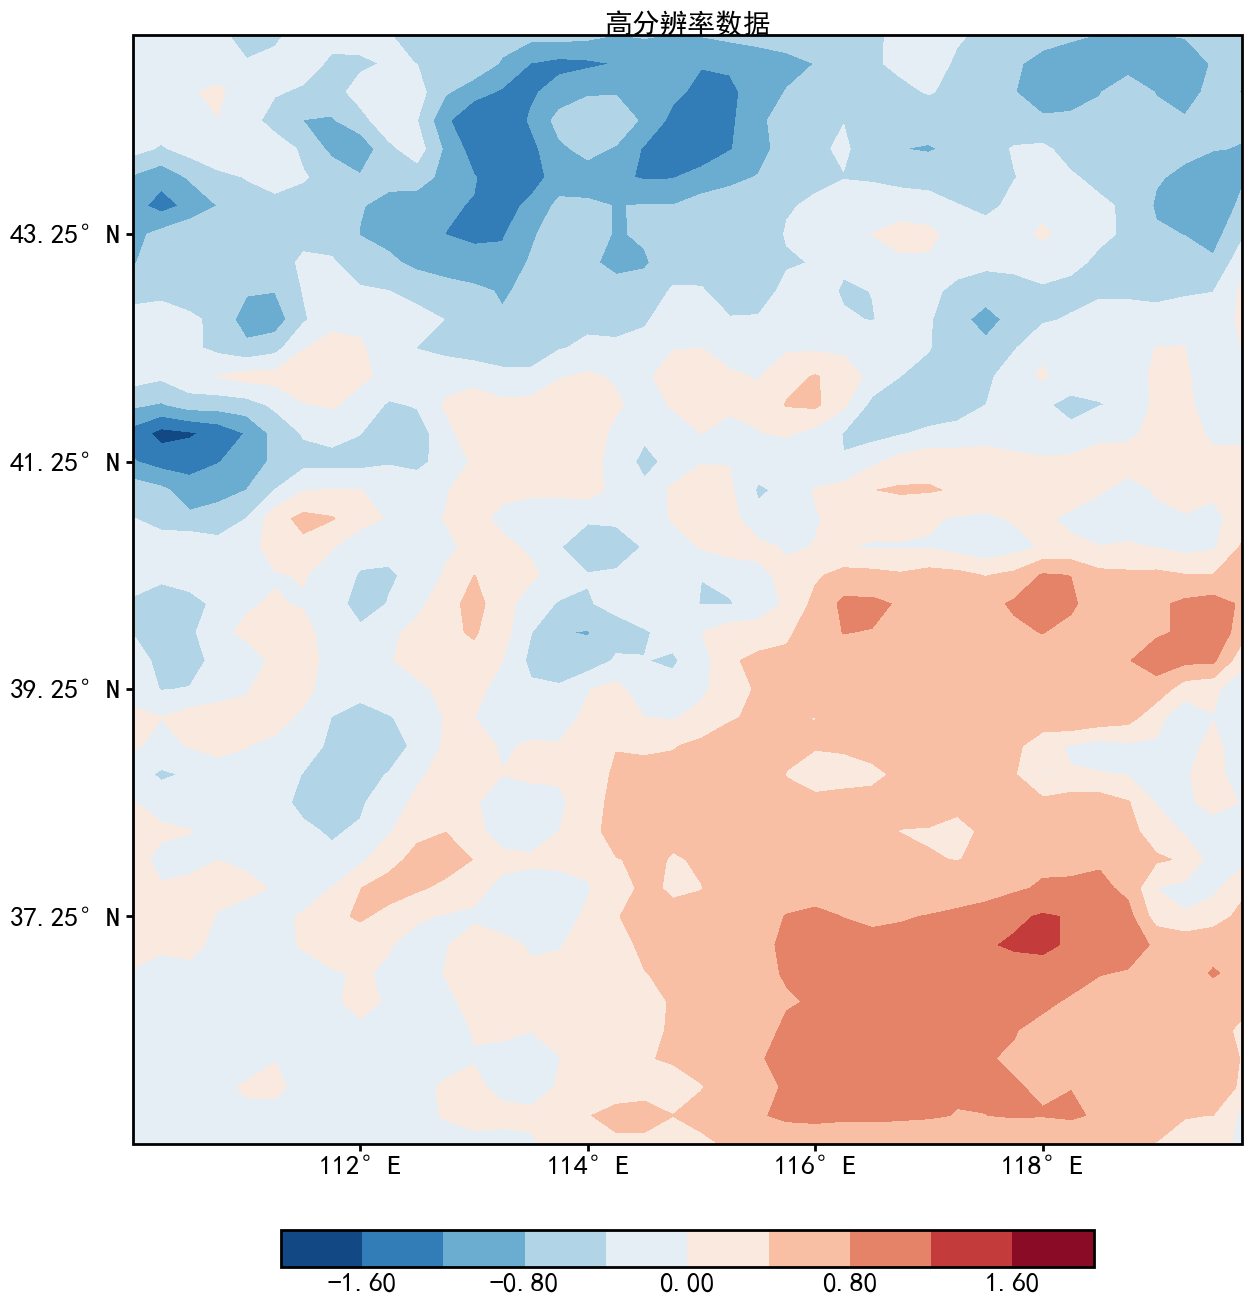

<Figure size 640x480 with 0 Axes>

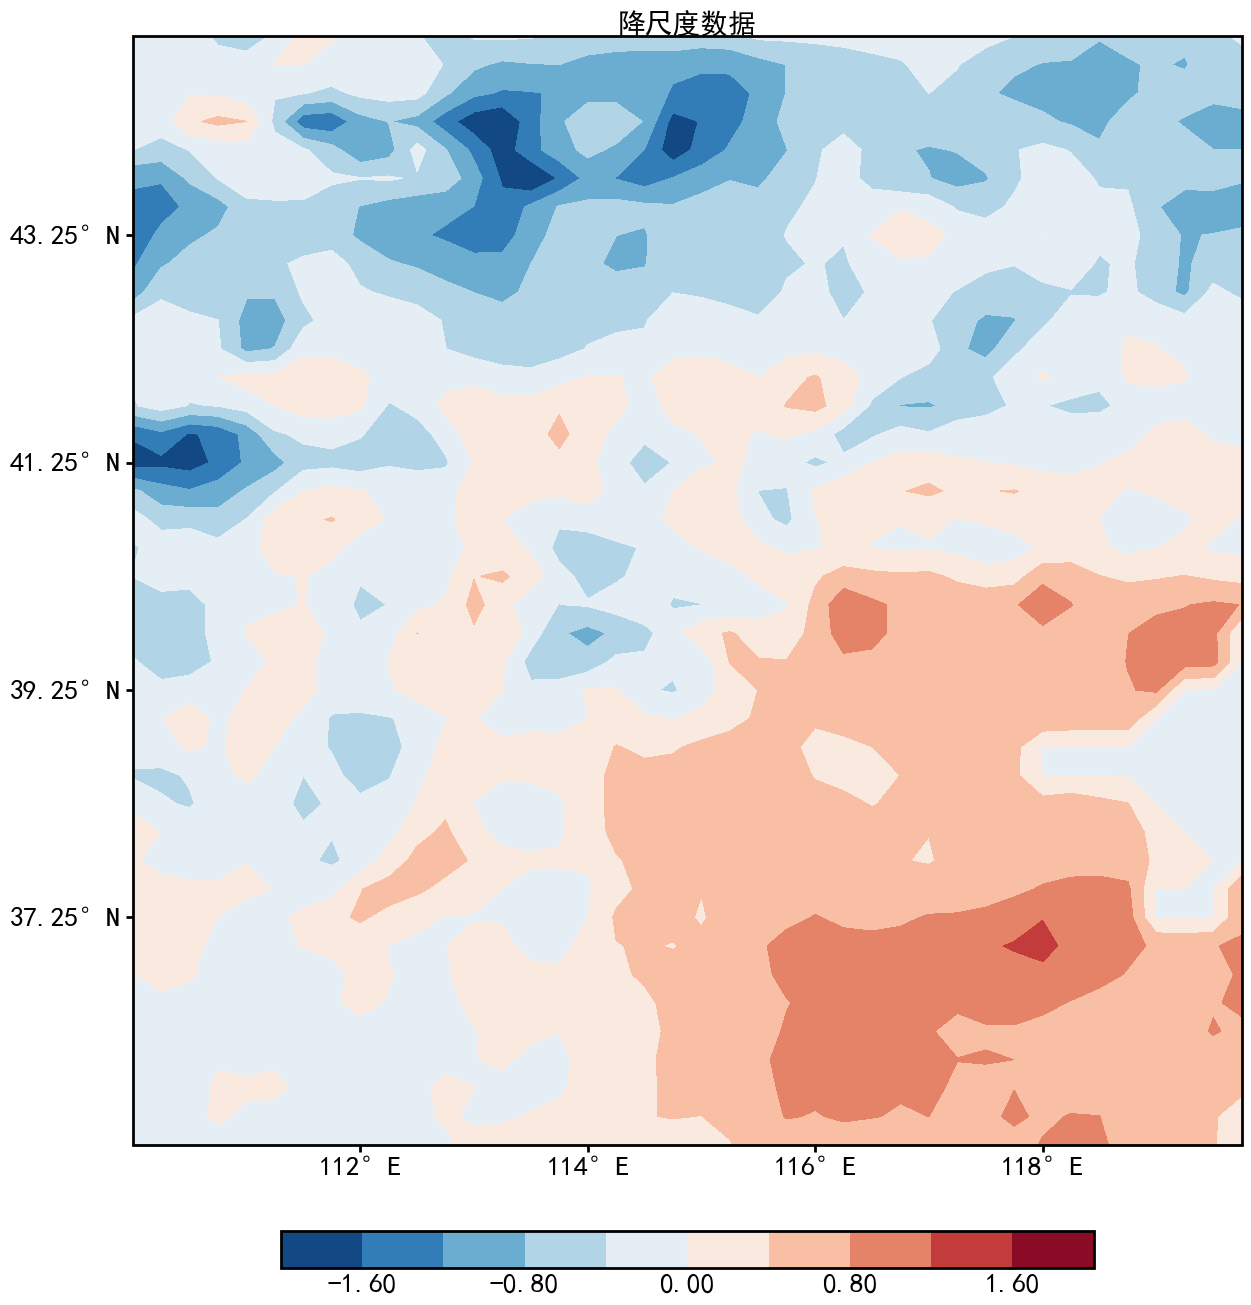

<Figure size 640x480 with 0 Axes>

In [8]:
import Auto_paint_self
Auto_paint_self.Autoshaded_quiver(testy[0,:,:],None,None,None,lon,lat,None,None,latlow,lattop,lonleft,lonright,'shaded','xy',picturenum=1,row=1,column=1,dpi=600,shadedcolor=None,ifshp='no',shpname=None,ifsave='no',savename=None,valuemodel='+-',ifself_vmax_vmin='yes',selfvmax =2.0,selfvmin=-2.0,shaded_quiver_title='高分辨率数据',ifline='no',ifclabel='no',ifcolorbar='yes',ifhatch='no',hatchpoint=None,hatchvalue=None,quiverscale=1,xspace=2,yspace=2,zspace=10000,labelsize=20,section=10.0,ifmaskout='no',maskoutarea=None,iftangle='no',tangle=None,ifchina='no',chinamap=None,ifsouthseamap='no',southseamap=None,southsealoc=[0.8, 0.21, 0.1, 0.15],ifglobal='no',projection_mode='plate',ifgridline='no',ifgeo='no',geo=None)
Auto_paint_self.Autoshaded_quiver(predicty[0,:,:],None,None,None,lon,lat,None,None,latlow,lattop,lonleft,lonright,'shaded','xy',picturenum=1,row=1,column=1,dpi=600,shadedcolor=None,ifshp='no',shpname=None,ifsave='no',savename=None,valuemodel='+-',ifself_vmax_vmin='yes',selfvmax =2.0,selfvmin=-2.0,shaded_quiver_title='降尺度数据',ifline='no',ifclabel='no',ifcolorbar='yes',ifhatch='no',hatchpoint=None,hatchvalue=None,quiverscale=1,xspace=2,yspace=2,zspace=10000,labelsize=20,section=10.0,ifmaskout='no',maskoutarea=None,iftangle='no',tangle=None,ifchina='no',chinamap=None,ifsouthseamap='no',southseamap=None,southsealoc=[0.8, 0.21, 0.1, 0.15],ifglobal='no',projection_mode='plate',ifgridline='no',ifgeo='no',geo=None)